In [55]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
import glob
# import aplpy
import sqlite3 
import gzip 
import io
import os

import copy
import json

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [56]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

# Set important constants

In [57]:
day_thres = 10 # days
now_jd = Time.now().jd
now_utc = Time.now()

## ***For viewing historical data

In [58]:
offset = 0 #days
now_jd -= offset

# Connect to database

In [65]:
conn = sqlite3.connect('../local/db/archival/sqlite_20210606.db')
# cutout_dir = '../local/cutouts/'

# Quick look at objects seen

In [71]:
df = pd.read_sql_query("SELECT * FROM ZTF_objects", conn)
df.columns = ['ztf_object_id', 'SIMBAD_otype', 'ra', 'dec', 'ROSAT_IAU_NAME',
       'SIMBAD_include', 'last_obs', 'seen_flag', 'interest_flag', 'notes',
       "EWMA8", "distpsnr", "objectidps", "sgmag", "srmag", "simag"]

In [72]:
df = df.loc[df['SIMBAD_include'] == 0]

In [74]:
df['SIMBAD_otype'].value_counts()

LP*     280
Mi*     276
None     86
RR*      52
SN*       6
G         2
BLL       2
No*       2
Pu*       2
Name: SIMBAD_otype, dtype: int64

In [10]:
pd.to_datetime([df['last_obs'].max()], unit='D', origin='julian')

DatetimeIndex(['2023-06-06 11:08:24.996480'], dtype='datetime64[ns]', freq=None)

In [11]:
df['dec'].min()

-27.9406196

# Read lightcurve data

In [40]:
cur = conn.cursor()
cur.execute("SELECT * FROM lightcurves")
dflc = pd.DataFrame(cur.fetchall())
dflc.columns = ['ztf_object_id', 'jd', 'fid', 'magpsf', 'sigmapsf', 'diffmaglim', 'isdiffpos', 'magnr', 'sigmagnr', 'field', 'rcid']
dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']] = dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']].astype(float)
dflc['fid'] = dflc['fid'].astype(int)

## ***If historical, drop all rows taken after "now_jd"

In [13]:
dflc = dflc.loc[(now_jd - dflc['jd']) > 0]

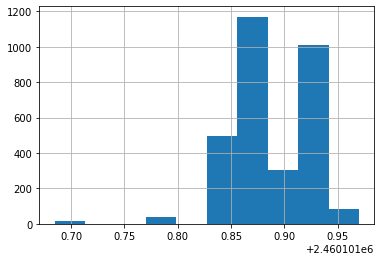

In [14]:
dflc['jd'].hist()

## Drop objects not seen in the past {day_thres} days

In [41]:
df = df.query(f'last_obs > {now_jd - day_thres}')
dflc = dflc.loc[dflc['ztf_object_id'].isin(df['ztf_object_id'])]

In [43]:
dflc['ztf_object_id'].unique()

array(['ZTF18abbpwzp', 'ZTF20abfxvkw', 'ZTF19aapzvno', 'ZTF18aabqewr',
       'ZTF18abucxou', 'ZTF18accnpno', 'ZTF18abcsatf', 'ZTF18aagtehr',
       'ZTF19aayengm', 'ZTF18adixgaa', 'ZTF18abnufvj', 'ZTF18abaxrbj',
       'ZTF18aazewjz', 'ZTF18aaxulyf', 'ZTF18aauqlfp', 'ZTF19aadovsf',
       'ZTF18abcobxs', 'ZTF18adkelrf', 'ZTF19aaduoap', 'ZTF19aadoqeg',
       'ZTF18abeaipz', 'ZTF18abdeaxq', 'ZTF18abjqlvc', 'ZTF18abcqxcy',
       'ZTF18abbnnpg', 'ZTF18ablqzkz', 'ZTF18adkekve', 'ZTF18acceapa',
       'ZTF18aaywfod', 'ZTF18abmbjio', 'ZTF18abcsvvv', 'ZTF18abjyaoe',
       'ZTF18aboatym', 'ZTF18abicwry', 'ZTF18abqcnmt', 'ZTF18abayjge',
       'ZTF18abikjxc', 'ZTF19aaimssx', 'ZTF18abnopvf', 'ZTF19abaglmg',
       'ZTF18abbsxqn', 'ZTF19abjswxv', 'ZTF18abbtxvi', 'ZTF18aayefby',
       'ZTF18abeqkzo', 'ZTF18abgxptv', 'ZTF18abgkhfy', 'ZTF18aajrtyr',
       'ZTF19aazgseh', 'ZTF19aargoso', 'ZTF19aargotw', 'ZTF19aargouz',
       'ZTF18aayejmu', 'ZTF18abclnad', 'ZTF18aazllkx', 'ZTF18absmdtf',
      

# Preprocess lightcurve data

### Impute missing magnr and sigmagnr

In [17]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

1.0

In [18]:
len(dflc['field'].dropna()) / len(dflc['field'])

1.0

In [19]:
len(dflc['rcid'].dropna()) / len(dflc['rcid'])

1.0

In [20]:
%%time
grp = dflc.groupby(['fid','field','rcid'])
impute_magnr = grp['magnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# print(impute_magnr)
impute_sigmagnr = grp['sigmagnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# print(impute_sigmagnr)

CPU times: user 334 ms, sys: 3.7 ms, total: 338 ms
Wall time: 336 ms


In [21]:
%%time
for idx, grpi in grp:
    w = np.isnan(grpi['magnr'])
    w2 = grpi[w].index
    dflc.loc[w2,'magnr'] = impute_magnr[idx]
    dflc.loc[w2,'sigmagnr'] = impute_sigmagnr[idx]

CPU times: user 762 ms, sys: 16 ms, total: 778 ms
Wall time: 772 ms


In [22]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

1.0

### Calculate DC magnitude

In [44]:
%%time
dflc['sign'] = 2* (dflc['isdiffpos'] == 't') - 1

u = 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf'])
dflc['dc_mag'] = -2.5 * np.log10(u)
dflc['dc_sigmag'] = np.sqrt(
    (10**(-0.4*dflc['magnr'])* dflc['sigmagnr']) **2. + 
    (10**(-0.4*dflc['magpsf']) * dflc['sigmapsf'])**2.) / u
dflc['dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim']))
dflc['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim']))

CPU times: user 25.1 ms, sys: 845 µs, total: 26 ms
Wall time: 23.8 ms


### Drop 0.5% of most uncertain obs

In [24]:
%%time
thres = dflc['dc_sigmag'].quantile(.995)
dflc = dflc.loc[~(dflc['dc_sigmag'] > thres)]

CPU times: user 12.5 ms, sys: 6.11 ms, total: 18.6 ms
Wall time: 15.9 ms


### Create new column with ulims subsituting nan dc_mag

In [25]:
%%time
dflc['combined_mag_ulim'] = [dflc.loc[ii, 'dc_mag_ulim'] if pd.isna(dflc.loc[ii, 'dc_mag']) else dflc.loc[ii, 'dc_mag'] for ii in dflc.index]

CPU times: user 42.1 ms, sys: 1.11 ms, total: 43.2 ms
Wall time: 40.7 ms


In [26]:
# dflc['combined_mag_ulim'] = [dflc.loc[ii, 'diffmaglim'] if pd.isna(dflc.loc[ii, 'dc_mag']) else dflc.loc[ii, 'dc_mag'] for ii in dflc.index]

### Exclude objects with otypes we are not interested in

In [45]:
%%time
dflc_interest = dflc[dflc['ztf_object_id'].isin(df.loc[df['SIMBAD_include'] == 1, 'ztf_object_id'])]
dflc_interest

CPU times: user 5.11 ms, sys: 4 µs, total: 5.11 ms
Wall time: 4.78 ms


,ztf_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid,sign,dc_mag,dc_sigmag,dc_mag_ulim,dc_mag_llim
8,ZTF18abbpwzp,2.460102e+06,1,18.614252,0.102119,19.444616,f,18.620001,0.019,377.0,40.0,-1,NaN,-19.666153,18.203259,19.305019
12,ZTF20abfxvkw,2.460102e+06,1,17.363220,0.046392,18.955063,t,22.020000,0.293,275.0,0.0,1,17.348427,0.045936,18.892380,NaN
13,ZTF19aapzvno,2.460102e+06,1,14.444130,0.026277,19.009731,t,15.774000,0.025,275.0,51.0,1,14.164462,0.021088,15.720219,15.830585
18,ZTF18aabqewr,2.460102e+06,1,17.164656,0.046755,19.705282,f,17.162001,0.017,626.0,25.0,-1,23.692465,20.325219,17.062383,17.271690
19,ZTF18abucxou,2.460102e+06,1,14.617811,0.029814,19.753698,t,18.490999,0.022,534.0,31.0,1,14.587585,0.029002,18.195709,18.897897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,ZTF18abiyazb,2.460102e+06,1,17.426760,0.060387,19.205801,t,20.556999,0.075,437.0,56.0,1,17.367638,0.057325,18.930940,NaN
3109,ZTF18abkhkzw,2.460102e+06,1,18.157761,0.116828,19.205801,f,16.467001,0.021,437.0,56.0,-1,16.723917,0.040996,16.383184,16.557834
3112,ZTF20aamlhco,2.460102e+06,2,16.326181,0.034046,18.535240,t,19.393999,0.067,332.0,10.0,1,16.263659,0.032359,18.129266,NaN
3118,ZTF18abutyts,2.460102e+06,1,17.579428,0.069160,19.284945,t,16.071001,0.022,548.0,62.0,1,15.829381,0.022373,16.016157,16.128764


In [28]:
dflc_interest[['dc_mag', 'dc_mag_ulim', 'combined_mag_ulim']]

,dc_mag,dc_mag_ulim,combined_mag_ulim
8,NaN,18.203259,18.203259
12,17.348427,18.892380,17.348427
13,14.164462,15.720219,14.164462
18,23.692465,17.062383,23.692465
19,14.587585,18.195709,14.587585
...,...,...,...
3108,17.367638,18.930940,17.367638
3109,16.723917,16.383184,16.723917
3112,16.263659,18.129266,16.263659
3118,15.829381,16.016157,15.829381


### Set df index to id and filter, then sort by time

In [46]:
%%time
dflc_interest['utc'] = pd.to_datetime(dflc_interest['jd'], unit='D', origin='julian')
dflc_interest.set_index(['ztf_object_id', 'fid'], inplace=True)
dflc_interest = dflc_interest.sort_values('utc').sort_index()

CPU times: user 20 ms, sys: 3.07 ms, total: 23.1 ms
Wall time: 21.2 ms


### Get list of ids seen in the past X days

In [47]:
%%time
last_seen = dflc_interest.groupby('ztf_object_id')['jd'].max()
new_sources = last_seen.loc[(now_jd - last_seen) < day_thres].index

CPU times: user 2.84 ms, sys: 104 µs, total: 2.94 ms
Wall time: 2.5 ms


In [48]:
print(f"Number of new sources: {len(new_sources)}")

Number of new sources: 140


### Calculate exponential weighted moving averages
using timescales of 2, 8, and 28 days

In [32]:
%%time

# dflc_interest['ema2'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='2 days', times=x['utc']).mean()).values
dflc_interest['ema8'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='8 days', times=x['utc']).mean()).values
# dflc_interest['ema28'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='28 days', times=x['utc']).mean()).values

TypeError: ewm() got an unexpected keyword argument 'times'

In [33]:
%%time

# dflc_interest['combined_ema2'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='2 days', times=x['utc']).mean()).values
dflc_interest['combined_ema8'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='8 days', times=x['utc']).mean()).values
# dflc_interest['combined_ema28'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='28 days', times=x['utc']).mean()).values

TypeError: ewm() got an unexpected keyword argument 'times'

### Calculate our metric for outbursting

- Take difference between 8day halflife EWMA and dc_magnitude
- Take the 4 day halflife EWMA of these differences

In [73]:
%%time
dflc_interest['mag_ewm_diff8'] = dflc_interest['dc_mag'] - dflc_interest['ema8']
dflc_interest['mag_ewm_diff8_rolling4'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

Wall time: 3.2 s


In [74]:
%%time
dflc_interest['combined_mag_ewm_diff8'] = dflc_interest['combined_mag_ulim'] - dflc_interest['combined_ema8']
dflc_interest['combined_mag_ewm_diff8_rolling4'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

Wall time: 3.44 s


### Get data for new sources only and time range we care about 

In [75]:
dflc_interest_new = dflc_interest.loc[new_sources]

In [76]:
ndays_thres = 30
dflc_interest_new = dflc_interest_new.loc[(now_jd - dflc_interest_new['jd']) < ndays_thres]

### Sort our data by max abs magnitude of our metric in the past X day

In [49]:
metric_days = 5

In [51]:
recent = dflc_interest.loc[(now_jd - dflc_interest['jd']) < metric_days]
# order_by_max = recent.groupby("ztf_object_id")['mag_ewm_diff8_rolling4'].apply(lambda x: x.min()).sort_values(ascending=True).index

### Investigate distribution of metric

# Visualize results

In [37]:
from plotting_helpers import plot_dc_lightcurve, plot_dc_lightcurve_lim, mark_seen, show_stamps, plot_cutout, update_value

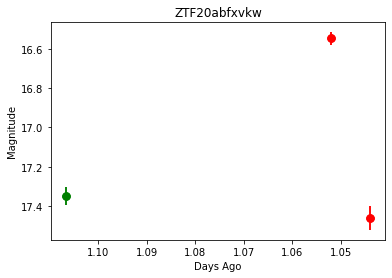

https://lasair.roe.ac.uk/object/ZTF20abfxvkw/


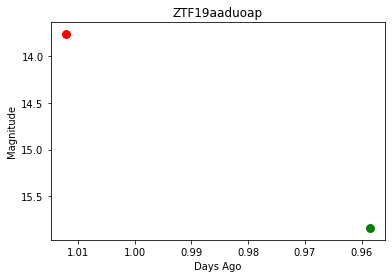

https://lasair.roe.ac.uk/object/ZTF19aaduoap/


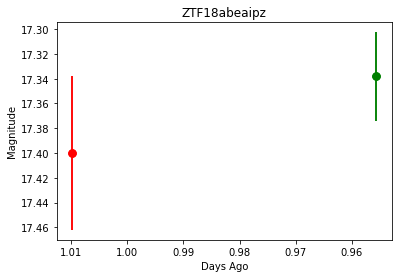

https://lasair.roe.ac.uk/object/ZTF18abeaipz/


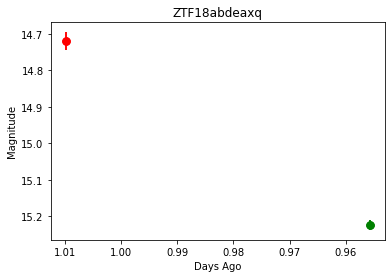

https://lasair.roe.ac.uk/object/ZTF18abdeaxq/


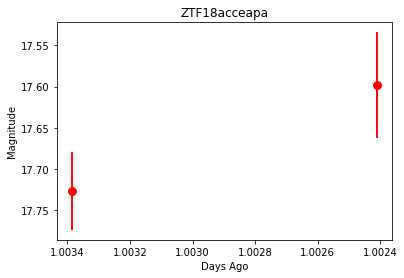

https://lasair.roe.ac.uk/object/ZTF18acceapa/


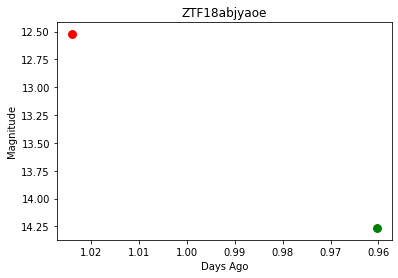

https://lasair.roe.ac.uk/object/ZTF18abjyaoe/


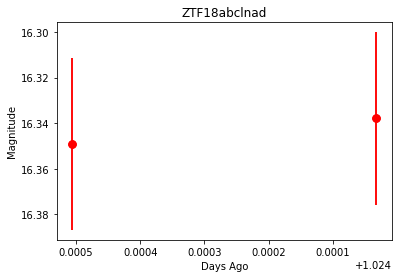

https://lasair.roe.ac.uk/object/ZTF18abclnad/


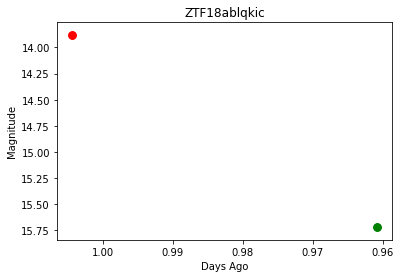

https://lasair.roe.ac.uk/object/ZTF18ablqkic/


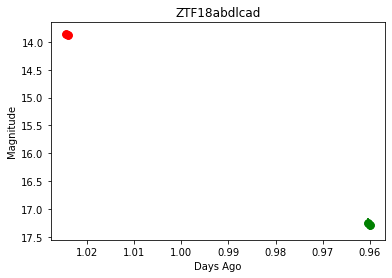

https://lasair.roe.ac.uk/object/ZTF18abdlcad/


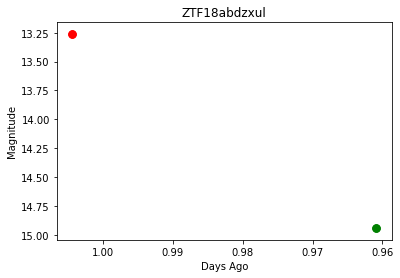

https://lasair.roe.ac.uk/object/ZTF18abdzxul/


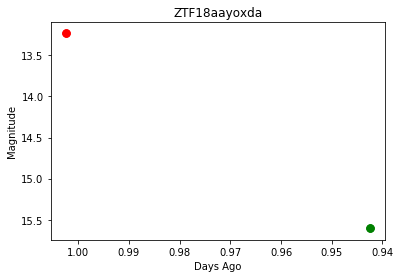

https://lasair.roe.ac.uk/object/ZTF18aayoxda/


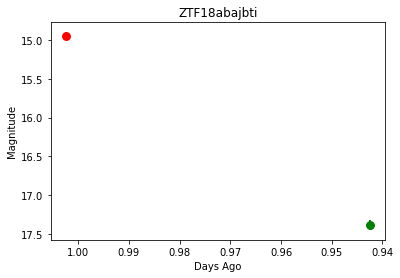

https://lasair.roe.ac.uk/object/ZTF18abajbti/


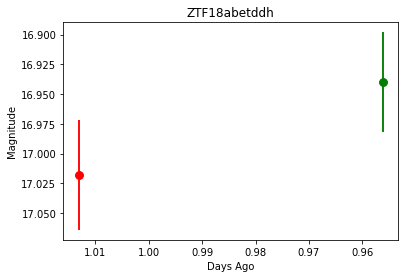

https://lasair.roe.ac.uk/object/ZTF18abetddh/


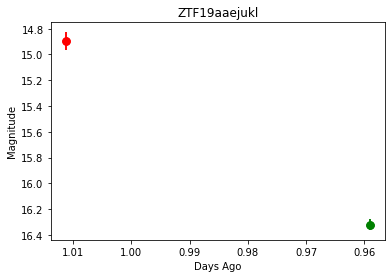

https://lasair.roe.ac.uk/object/ZTF19aaejukl/


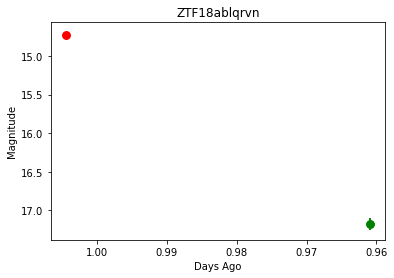

https://lasair.roe.ac.uk/object/ZTF18ablqrvn/


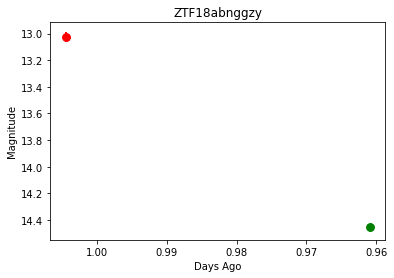

https://lasair.roe.ac.uk/object/ZTF18abnggzy/


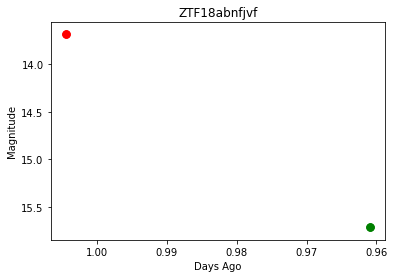

https://lasair.roe.ac.uk/object/ZTF18abnfjvf/


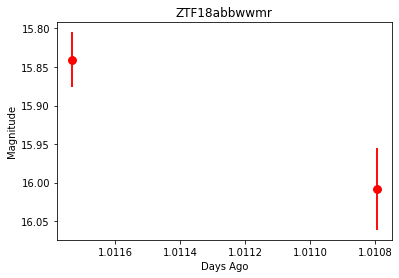

https://lasair.roe.ac.uk/object/ZTF18abbwwmr/


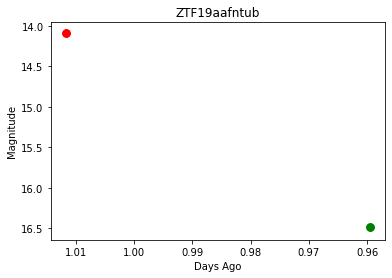

https://lasair.roe.ac.uk/object/ZTF19aafntub/


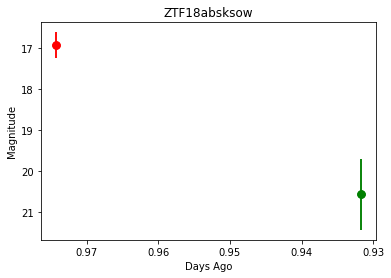

https://lasair.roe.ac.uk/object/ZTF18absksow/


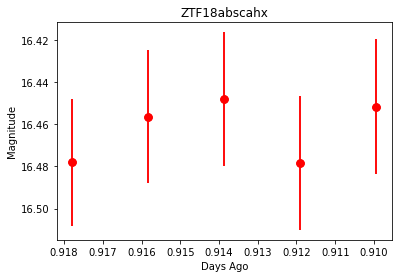

https://lasair.roe.ac.uk/object/ZTF18abscahx/


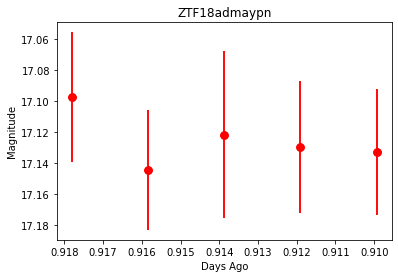

https://lasair.roe.ac.uk/object/ZTF18admaypn/


In [53]:
for x in dflc['ztf_object_id'].unique():
    sub = recent.loc[x].dropna(subset=['dc_mag'])
    if len(sub) > 2:
        _ = plot_dc_lightcurve(sub.reset_index(), x, offset=offset)
        print(f'https://lasair.roe.ac.uk/object/{x}/')
        # show_stamps(x)
    # mark_seen(conn, x)


### Do the same, but now include dc_mag_ulim into the rolling calculations

In [81]:
recent = dflc_interest_new.loc[(now_jd - dflc_interest_new['jd']) < metric_days]
combined_order_by_max = recent.groupby("ztf_object_id")['combined_mag_ewm_diff8_rolling4'].apply(lambda x: x.min()).sort_values(ascending=True).index

In [82]:
len(combined_order_by_max)

756

In [83]:
df.query('ztf_object_id=="ZTF18adbafew"')

,ztf_object_id,SIMBAD_otype,ra,dec,ROSAT_IAU_NAME,SIMBAD_include,last_obs,seen_flag,interest_flag,notes
21864,ZTF18adbafew,No*,244.823698,-2.49156,2SXPS J161917.7-022930,1.0,2.459458e+06,0.0,1.0,None


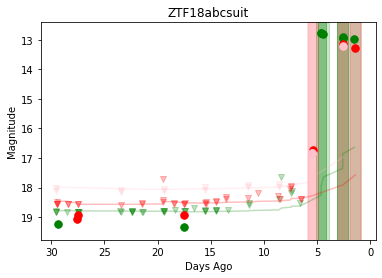

https://lasair.roe.ac.uk/object/ZTF18abcsuit/


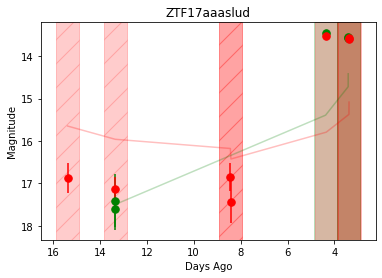

https://lasair.roe.ac.uk/object/ZTF17aaaslud/


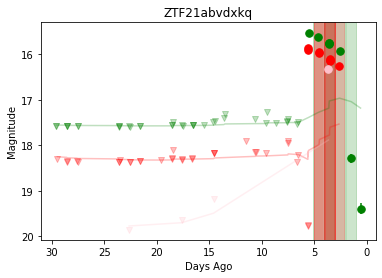

https://lasair.roe.ac.uk/object/ZTF21abvdxkq/


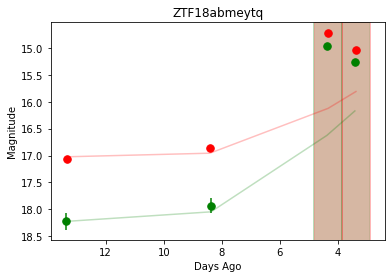

https://lasair.roe.ac.uk/object/ZTF18abmeytq/


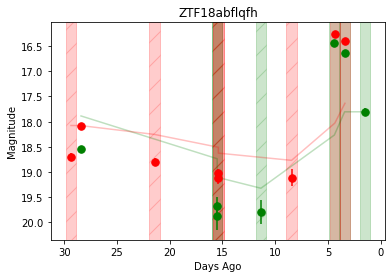

https://lasair.roe.ac.uk/object/ZTF18abflqfh/


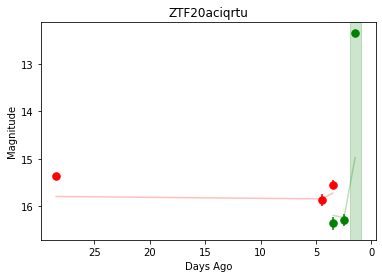

https://lasair.roe.ac.uk/object/ZTF20aciqrtu/


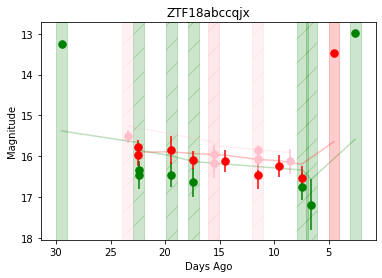

https://lasair.roe.ac.uk/object/ZTF18abccqjx/


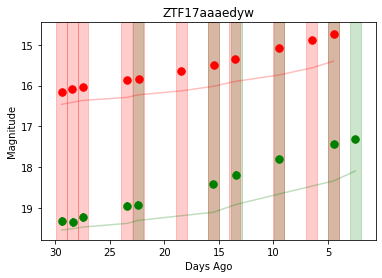

https://lasair.roe.ac.uk/object/ZTF17aaaedyw/


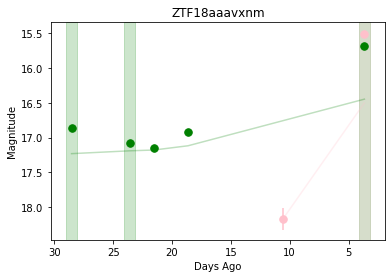

https://lasair.roe.ac.uk/object/ZTF18aaavxnm/


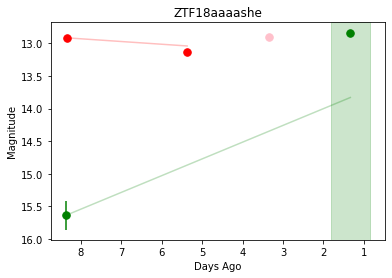

https://lasair.roe.ac.uk/object/ZTF18aaaashe/


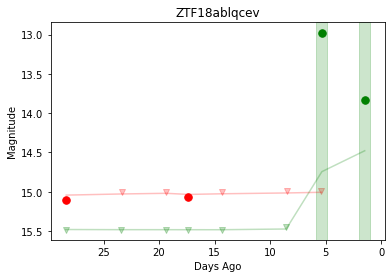

https://lasair.roe.ac.uk/object/ZTF18ablqcev/


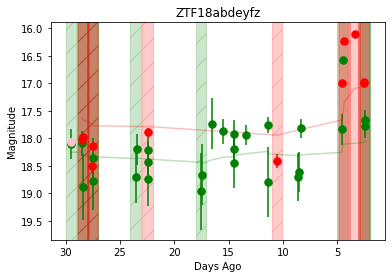

https://lasair.roe.ac.uk/object/ZTF18abdeyfz/


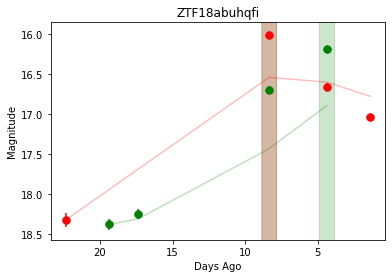

https://lasair.roe.ac.uk/object/ZTF18abuhqfi/


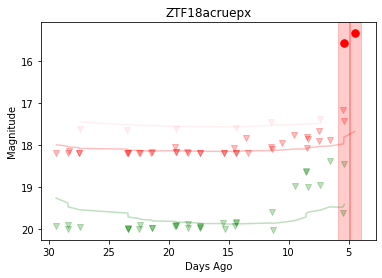

https://lasair.roe.ac.uk/object/ZTF18acruepx/


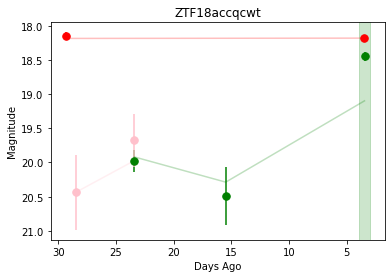

https://lasair.roe.ac.uk/object/ZTF18accqcwt/


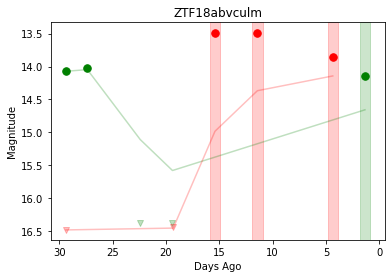

https://lasair.roe.ac.uk/object/ZTF18abvculm/


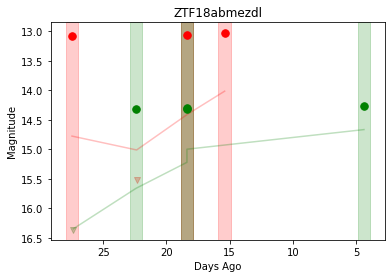

https://lasair.roe.ac.uk/object/ZTF18abmezdl/


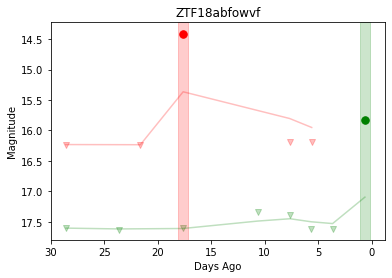

https://lasair.roe.ac.uk/object/ZTF18abfowvf/


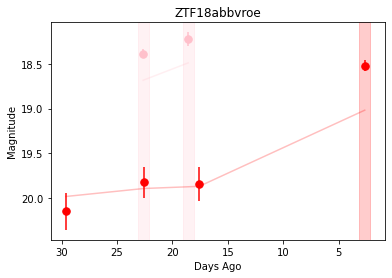

https://lasair.roe.ac.uk/object/ZTF18abbvroe/


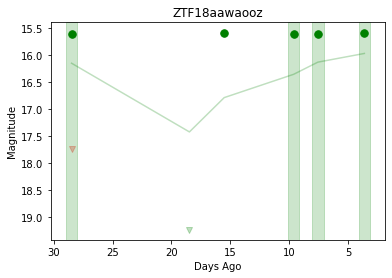

https://lasair.roe.ac.uk/object/ZTF18aawaooz/


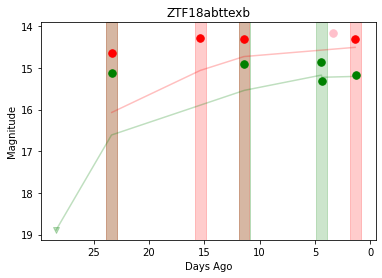

https://lasair.roe.ac.uk/object/ZTF18abttexb/


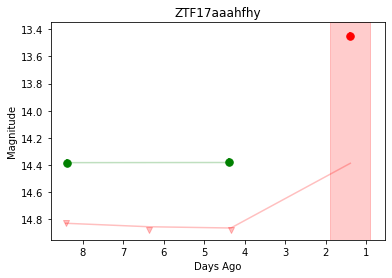

https://lasair.roe.ac.uk/object/ZTF17aaahfhy/


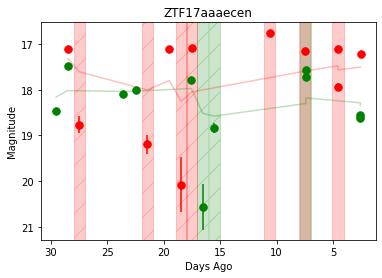

https://lasair.roe.ac.uk/object/ZTF17aaaecen/


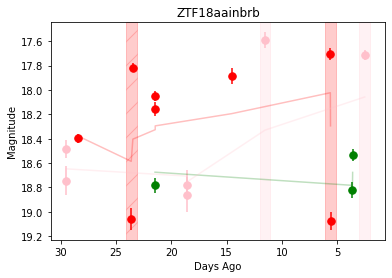

https://lasair.roe.ac.uk/object/ZTF18aainbrb/


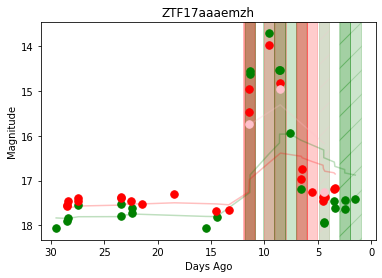

https://lasair.roe.ac.uk/object/ZTF17aaaemzh/


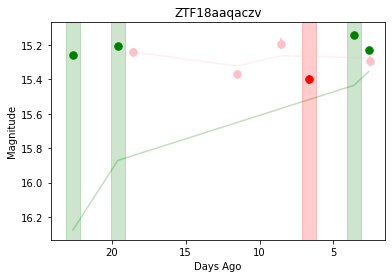

https://lasair.roe.ac.uk/object/ZTF18aaqaczv/


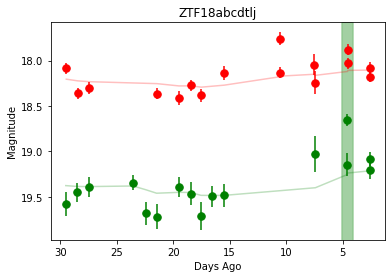

https://lasair.roe.ac.uk/object/ZTF18abcdtlj/


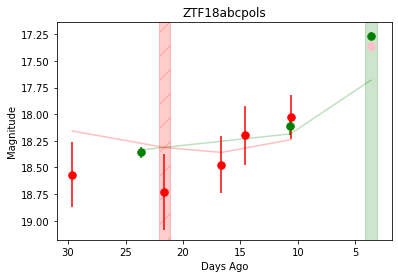

https://lasair.roe.ac.uk/object/ZTF18abcpols/


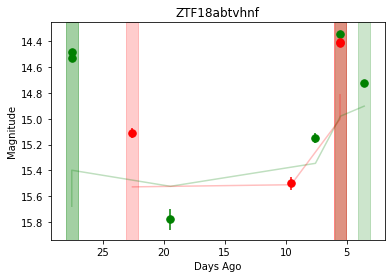

https://lasair.roe.ac.uk/object/ZTF18abtvhnf/


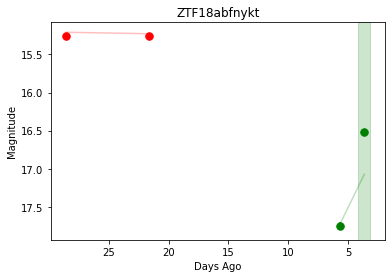

https://lasair.roe.ac.uk/object/ZTF18abfnykt/


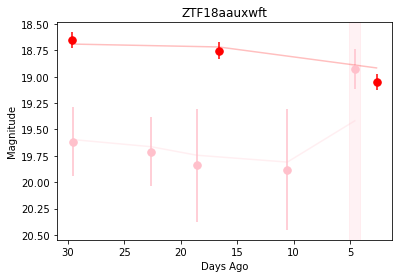

https://lasair.roe.ac.uk/object/ZTF18aauxwft/


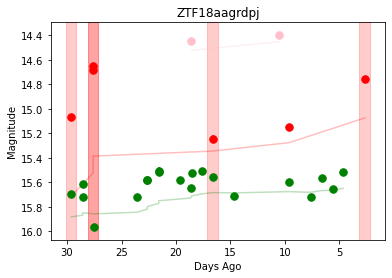

https://lasair.roe.ac.uk/object/ZTF18aagrdpj/


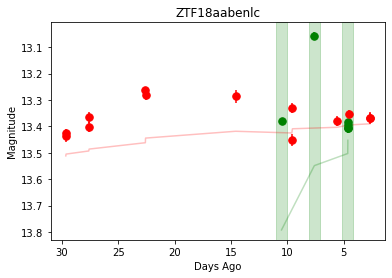

https://lasair.roe.ac.uk/object/ZTF18aabenlc/


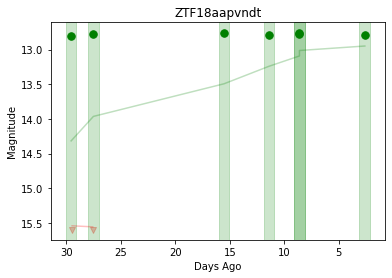

https://lasair.roe.ac.uk/object/ZTF18aapvndt/


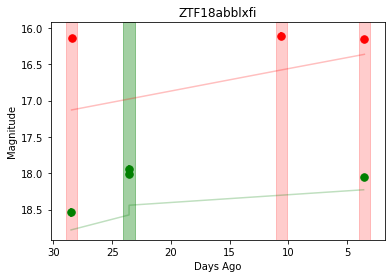

https://lasair.roe.ac.uk/object/ZTF18abblxfi/


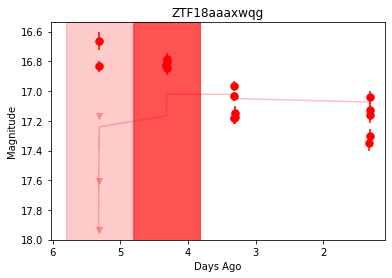

https://lasair.roe.ac.uk/object/ZTF18aaaxwqg/


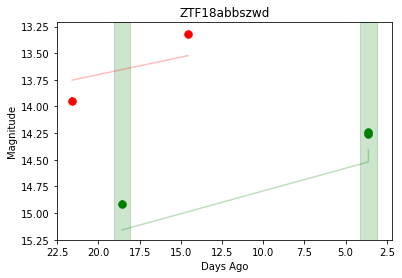

https://lasair.roe.ac.uk/object/ZTF18abbszwd/


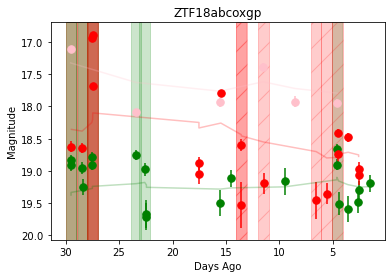

https://lasair.roe.ac.uk/object/ZTF18abcoxgp/


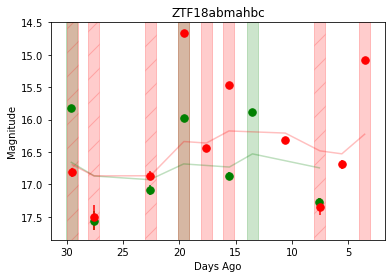

https://lasair.roe.ac.uk/object/ZTF18abmahbc/


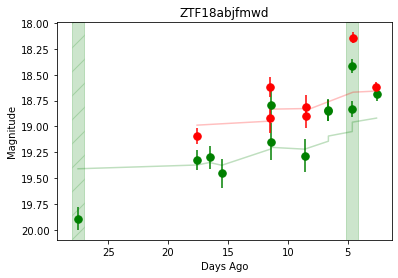

https://lasair.roe.ac.uk/object/ZTF18abjfmwd/


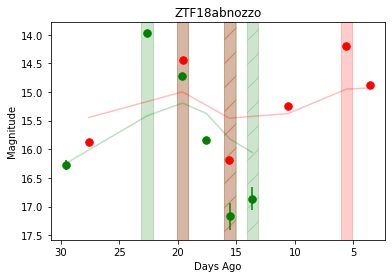

https://lasair.roe.ac.uk/object/ZTF18abnozzo/


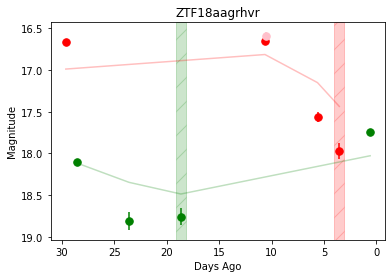

https://lasair.roe.ac.uk/object/ZTF18aagrhvr/


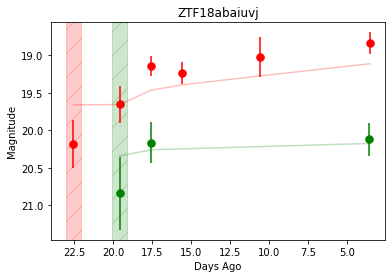

https://lasair.roe.ac.uk/object/ZTF18abaiuvj/


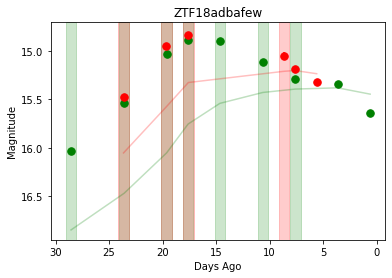

https://lasair.roe.ac.uk/object/ZTF18adbafew/


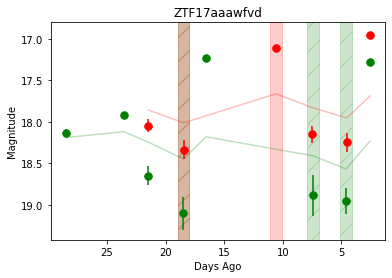

https://lasair.roe.ac.uk/object/ZTF17aaawfvd/


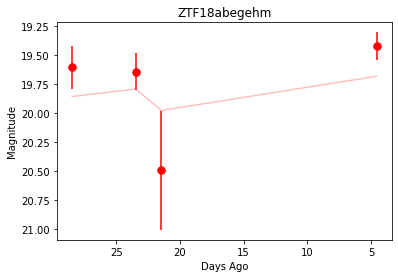

https://lasair.roe.ac.uk/object/ZTF18abegehm/


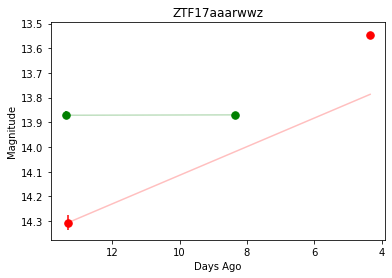

https://lasair.roe.ac.uk/object/ZTF17aaarwwz/


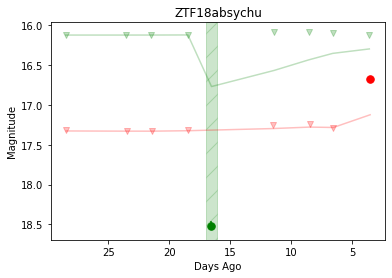

https://lasair.roe.ac.uk/object/ZTF18absychu/


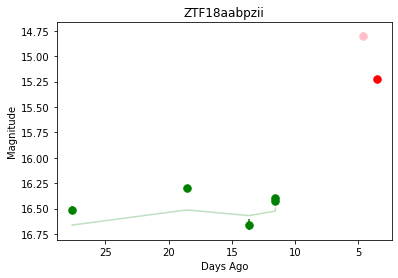

https://lasair.roe.ac.uk/object/ZTF18aabpzii/


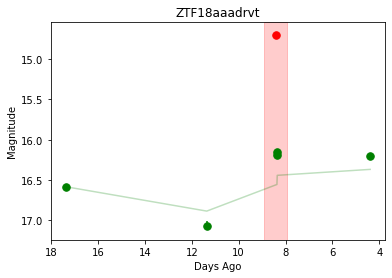

https://lasair.roe.ac.uk/object/ZTF18aaadrvt/


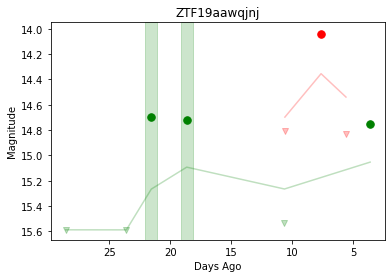

https://lasair.roe.ac.uk/object/ZTF19aawqjnj/


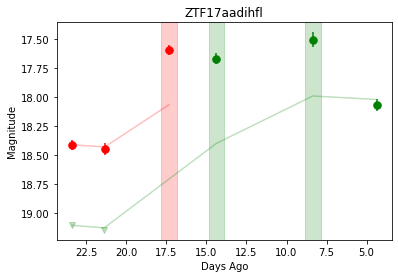

https://lasair.roe.ac.uk/object/ZTF17aadihfl/


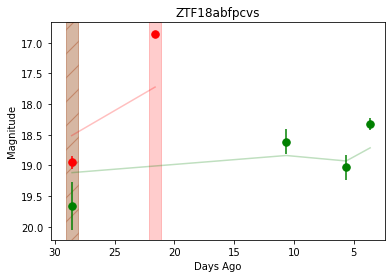

https://lasair.roe.ac.uk/object/ZTF18abfpcvs/


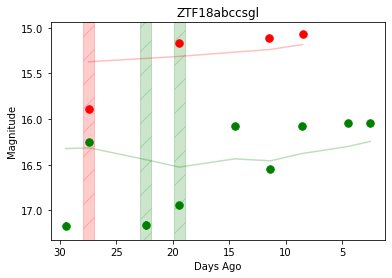

https://lasair.roe.ac.uk/object/ZTF18abccsgl/


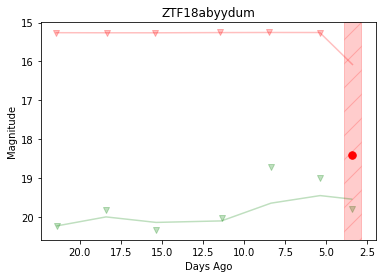

https://lasair.roe.ac.uk/object/ZTF18abyydum/


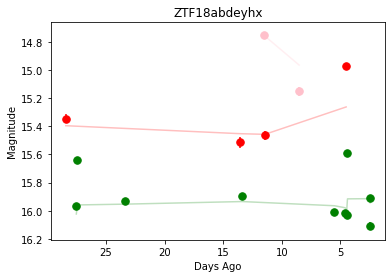

https://lasair.roe.ac.uk/object/ZTF18abdeyhx/


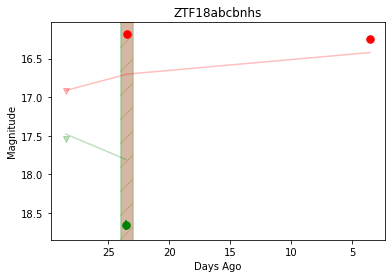

https://lasair.roe.ac.uk/object/ZTF18abcbnhs/


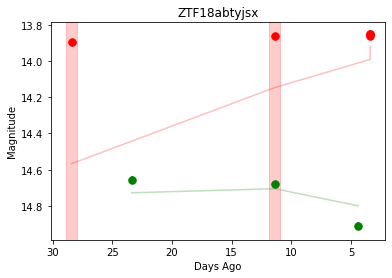

https://lasair.roe.ac.uk/object/ZTF18abtyjsx/


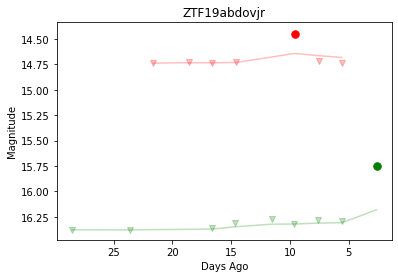

https://lasair.roe.ac.uk/object/ZTF19abdovjr/


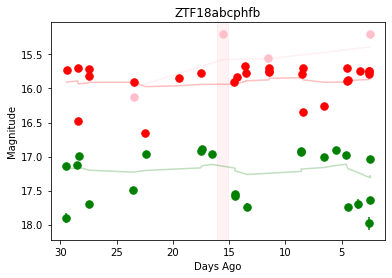

https://lasair.roe.ac.uk/object/ZTF18abcphfb/


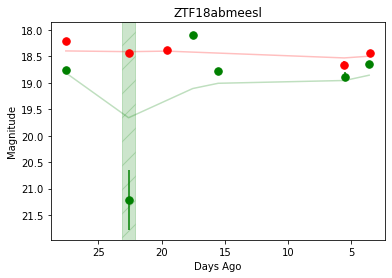

https://lasair.roe.ac.uk/object/ZTF18abmeesl/


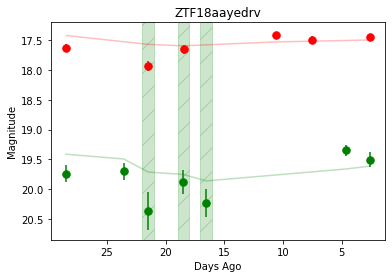

https://lasair.roe.ac.uk/object/ZTF18aayedrv/


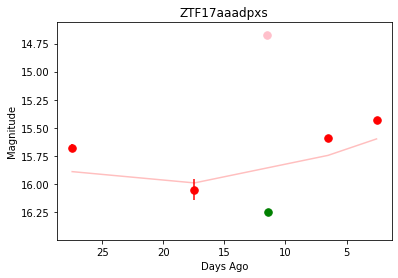

https://lasair.roe.ac.uk/object/ZTF17aaadpxs/


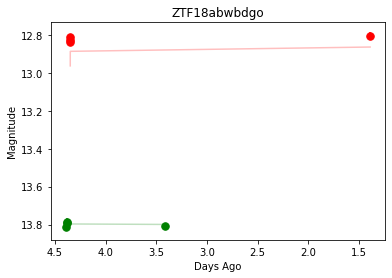

https://lasair.roe.ac.uk/object/ZTF18abwbdgo/


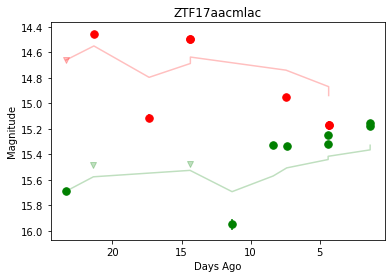

https://lasair.roe.ac.uk/object/ZTF17aacmlac/


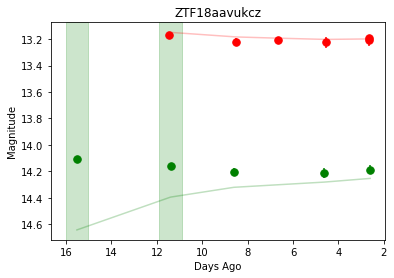

https://lasair.roe.ac.uk/object/ZTF18aavukcz/


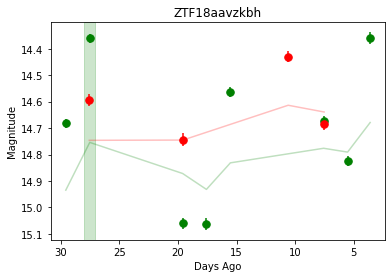

https://lasair.roe.ac.uk/object/ZTF18aavzkbh/


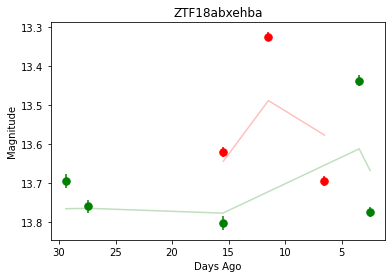

https://lasair.roe.ac.uk/object/ZTF18abxehba/


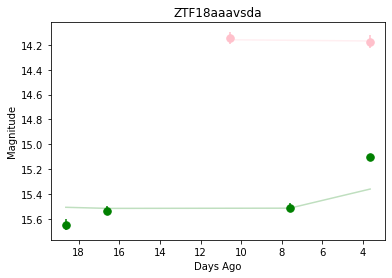

https://lasair.roe.ac.uk/object/ZTF18aaavsda/


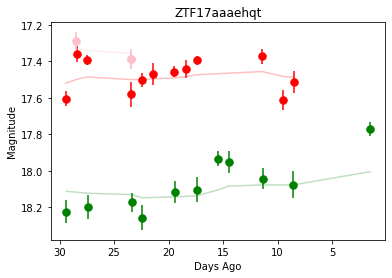

https://lasair.roe.ac.uk/object/ZTF17aaaehqt/


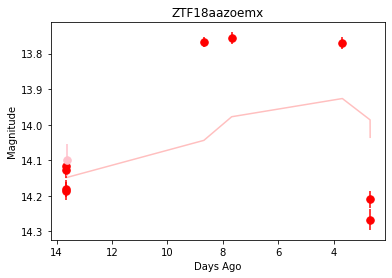

https://lasair.roe.ac.uk/object/ZTF18aazoemx/


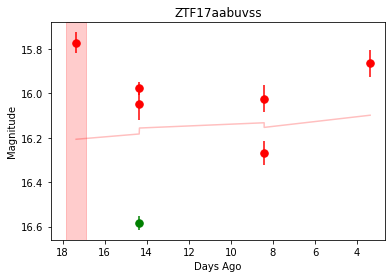

https://lasair.roe.ac.uk/object/ZTF17aabuvss/


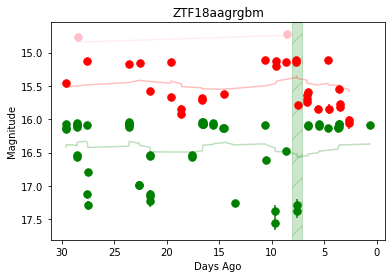

https://lasair.roe.ac.uk/object/ZTF18aagrgbm/


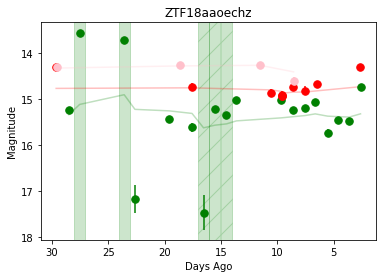

https://lasair.roe.ac.uk/object/ZTF18aaoechz/


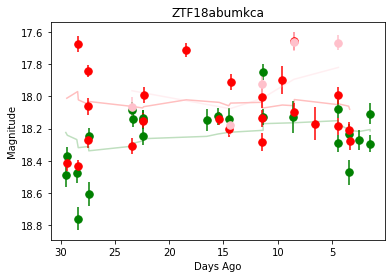

https://lasair.roe.ac.uk/object/ZTF18abumkca/


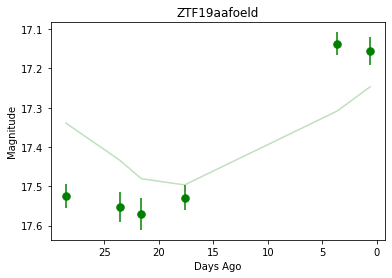

https://lasair.roe.ac.uk/object/ZTF19aafoeld/


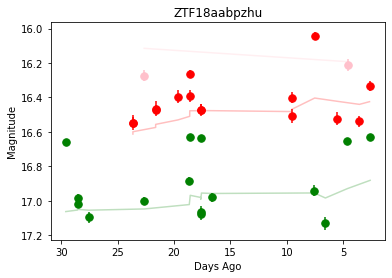

https://lasair.roe.ac.uk/object/ZTF18aabpzhu/


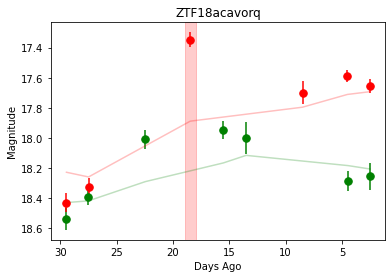

https://lasair.roe.ac.uk/object/ZTF18acavorq/


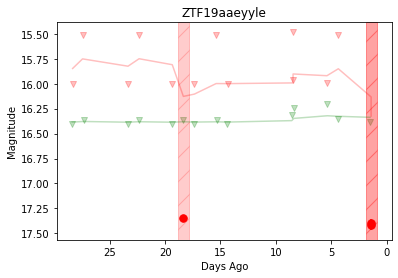

https://lasair.roe.ac.uk/object/ZTF19aaeyyle/


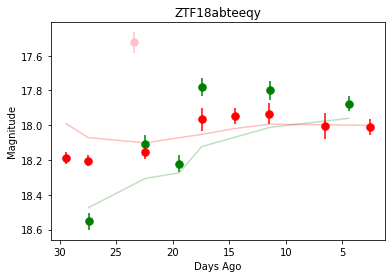

https://lasair.roe.ac.uk/object/ZTF18abteeqy/


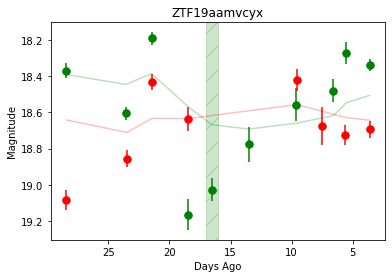

https://lasair.roe.ac.uk/object/ZTF19aamvcyx/


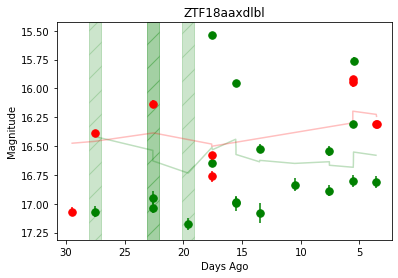

https://lasair.roe.ac.uk/object/ZTF18aaxdlbl/


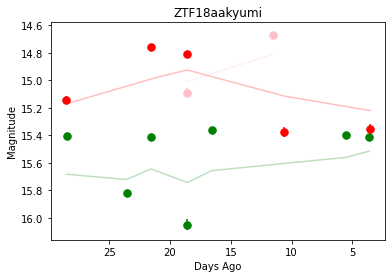

https://lasair.roe.ac.uk/object/ZTF18aakyumi/


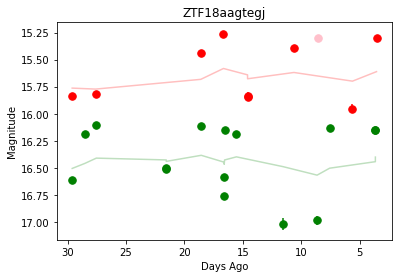

https://lasair.roe.ac.uk/object/ZTF18aagtegj/


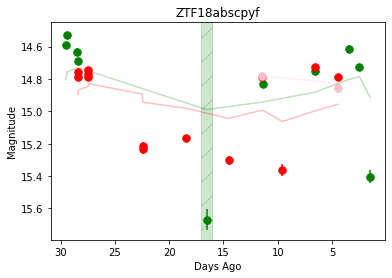

https://lasair.roe.ac.uk/object/ZTF18abscpyf/


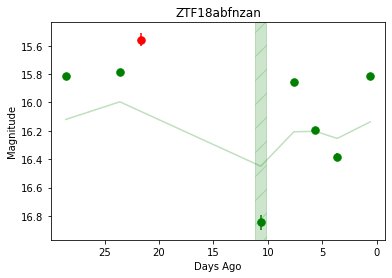

https://lasair.roe.ac.uk/object/ZTF18abfnzan/


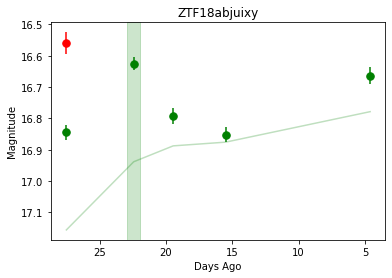

https://lasair.roe.ac.uk/object/ZTF18abjuixy/


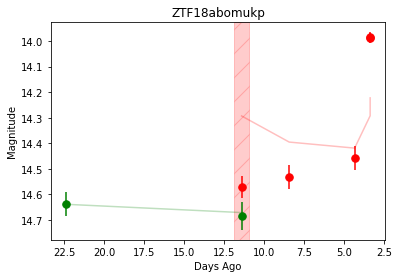

https://lasair.roe.ac.uk/object/ZTF18abomukp/


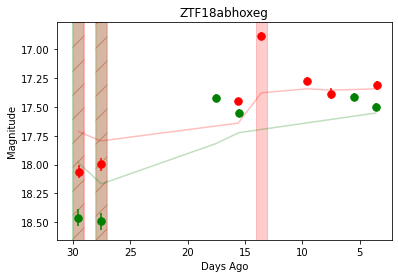

https://lasair.roe.ac.uk/object/ZTF18abhoxeg/


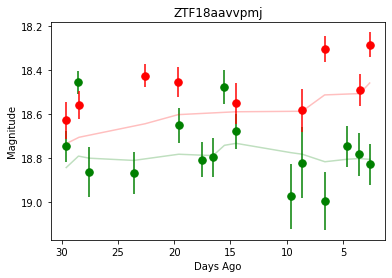

https://lasair.roe.ac.uk/object/ZTF18aavvpmj/


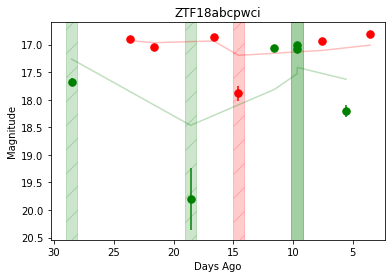

https://lasair.roe.ac.uk/object/ZTF18abcpwci/


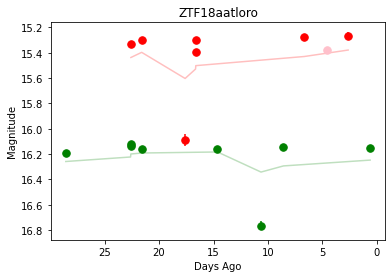

https://lasair.roe.ac.uk/object/ZTF18aatloro/


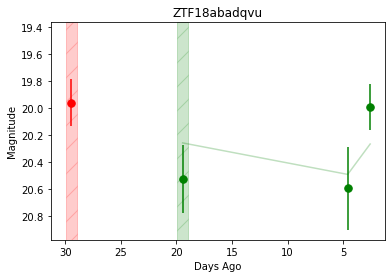

https://lasair.roe.ac.uk/object/ZTF18abadqvu/


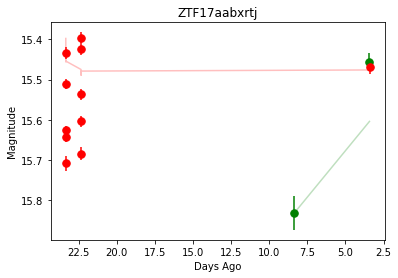

https://lasair.roe.ac.uk/object/ZTF17aabxrtj/


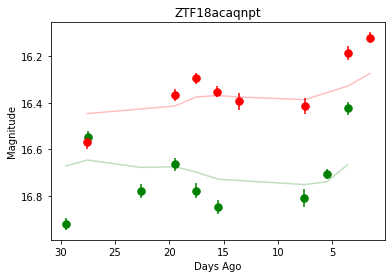

https://lasair.roe.ac.uk/object/ZTF18acaqnpt/


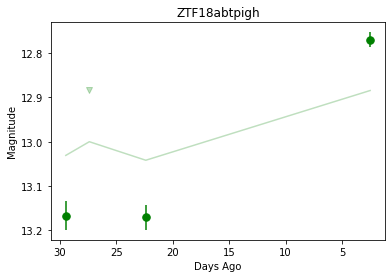

https://lasair.roe.ac.uk/object/ZTF18abtpigh/


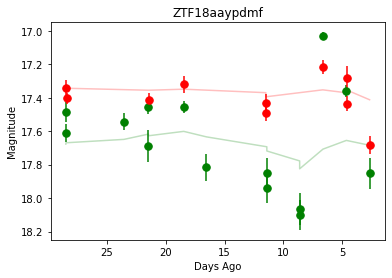

https://lasair.roe.ac.uk/object/ZTF18aaypdmf/


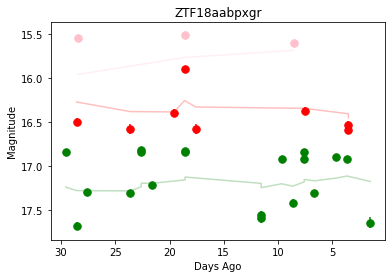

https://lasair.roe.ac.uk/object/ZTF18aabpxgr/


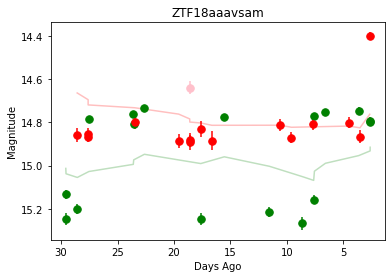

https://lasair.roe.ac.uk/object/ZTF18aaavsam/


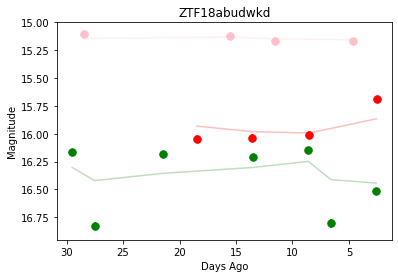

https://lasair.roe.ac.uk/object/ZTF18abudwkd/


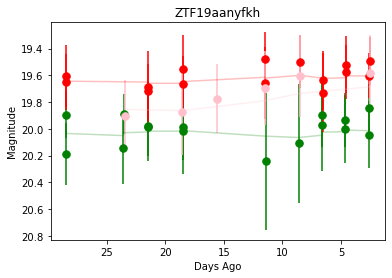

https://lasair.roe.ac.uk/object/ZTF19aanyfkh/


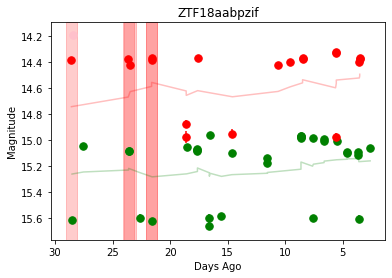

https://lasair.roe.ac.uk/object/ZTF18aabpzif/


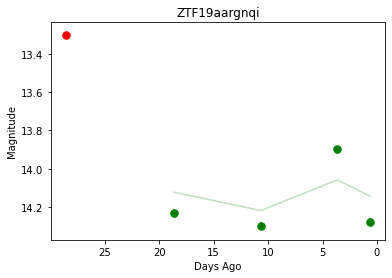

https://lasair.roe.ac.uk/object/ZTF19aargnqi/


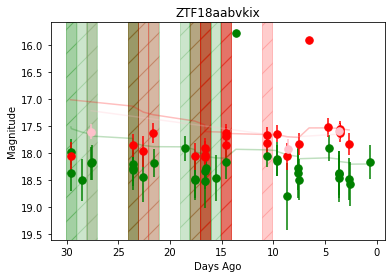

https://lasair.roe.ac.uk/object/ZTF18aabvkix/


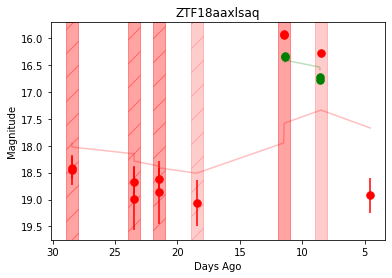

https://lasair.roe.ac.uk/object/ZTF18aaxlsaq/


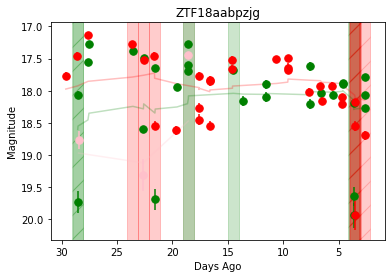

https://lasair.roe.ac.uk/object/ZTF18aabpzjg/


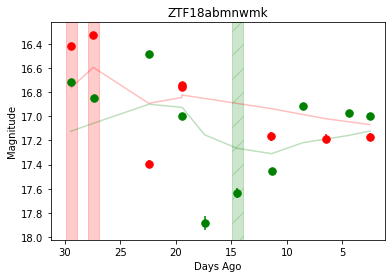

https://lasair.roe.ac.uk/object/ZTF18abmnwmk/


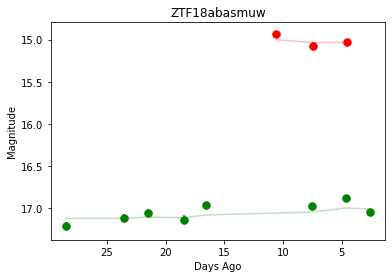

https://lasair.roe.ac.uk/object/ZTF18abasmuw/


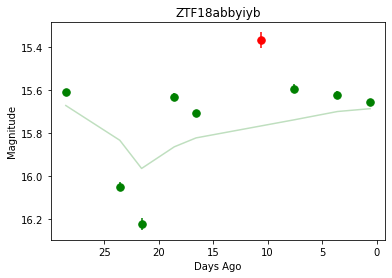

https://lasair.roe.ac.uk/object/ZTF18abbyiyb/


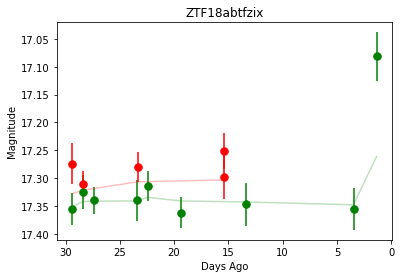

https://lasair.roe.ac.uk/object/ZTF18abtfzix/


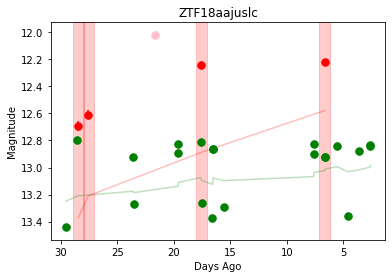

https://lasair.roe.ac.uk/object/ZTF18aajuslc/


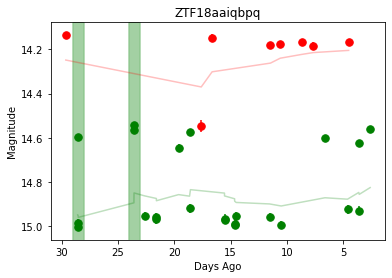

https://lasair.roe.ac.uk/object/ZTF18aaiqbpq/


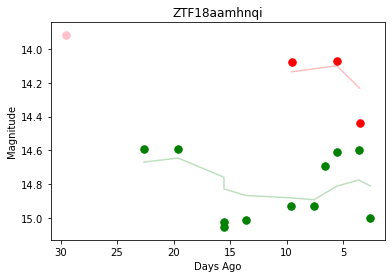

https://lasair.roe.ac.uk/object/ZTF18aamhnqi/


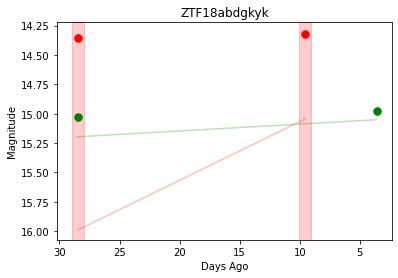

https://lasair.roe.ac.uk/object/ZTF18abdgkyk/


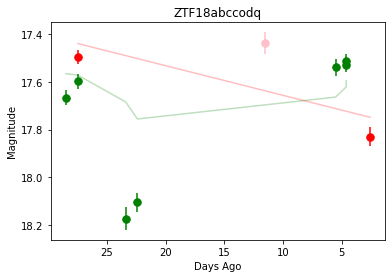

https://lasair.roe.ac.uk/object/ZTF18abccodq/


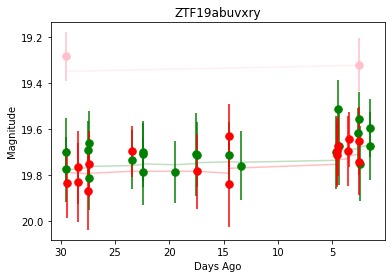

https://lasair.roe.ac.uk/object/ZTF19abuvxry/


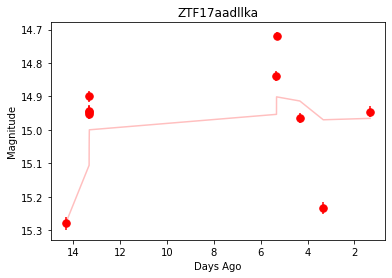

https://lasair.roe.ac.uk/object/ZTF17aadllka/


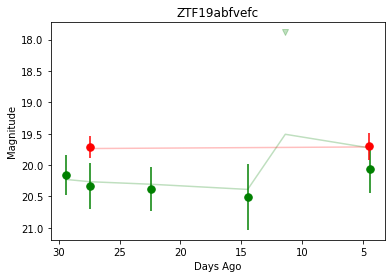

https://lasair.roe.ac.uk/object/ZTF19abfvefc/


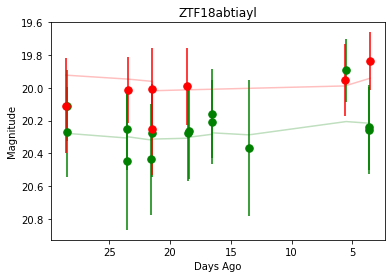

https://lasair.roe.ac.uk/object/ZTF18abtiayl/


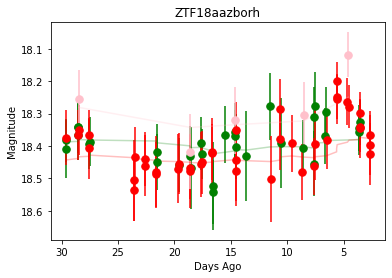

https://lasair.roe.ac.uk/object/ZTF18aazborh/


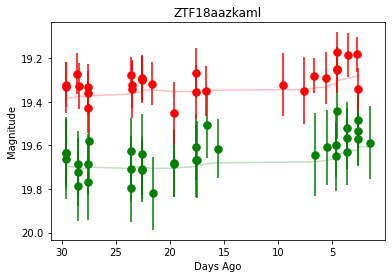

https://lasair.roe.ac.uk/object/ZTF18aazkaml/


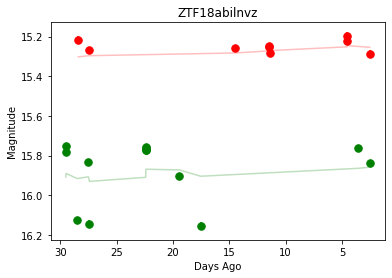

https://lasair.roe.ac.uk/object/ZTF18abilnvz/


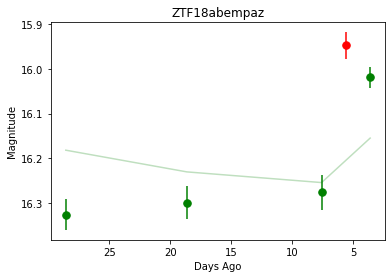

https://lasair.roe.ac.uk/object/ZTF18abempaz/


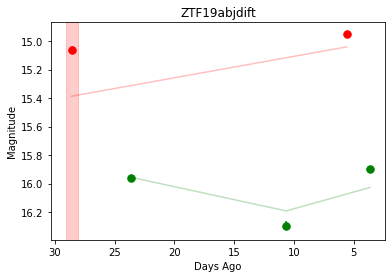

https://lasair.roe.ac.uk/object/ZTF19abjdift/


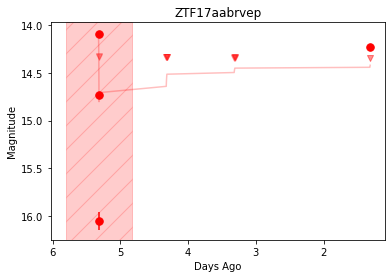

https://lasair.roe.ac.uk/object/ZTF17aabrvep/


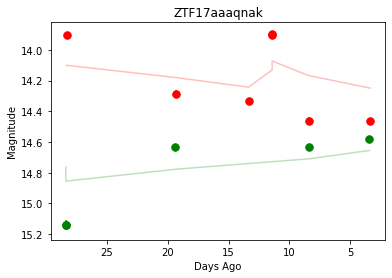

https://lasair.roe.ac.uk/object/ZTF17aaaqnak/


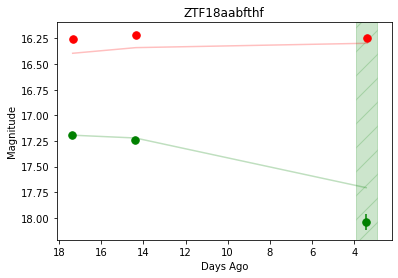

https://lasair.roe.ac.uk/object/ZTF18aabfthf/


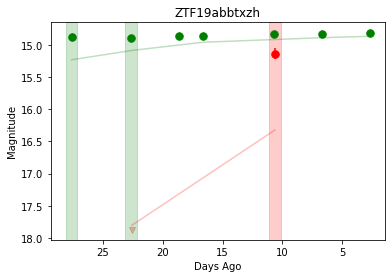

https://lasair.roe.ac.uk/object/ZTF19abbtxzh/


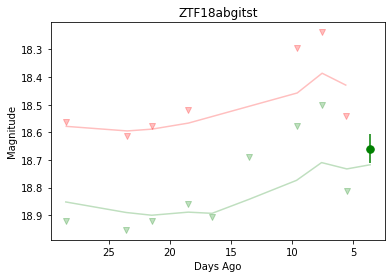

https://lasair.roe.ac.uk/object/ZTF18abgitst/


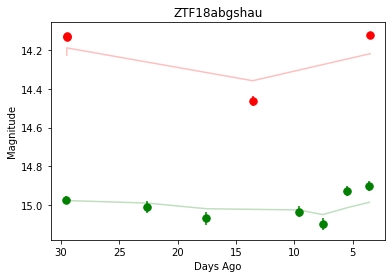

https://lasair.roe.ac.uk/object/ZTF18abgshau/


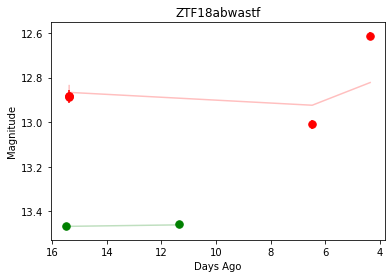

https://lasair.roe.ac.uk/object/ZTF18abwastf/


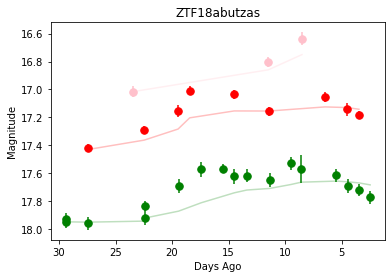

https://lasair.roe.ac.uk/object/ZTF18abutzas/


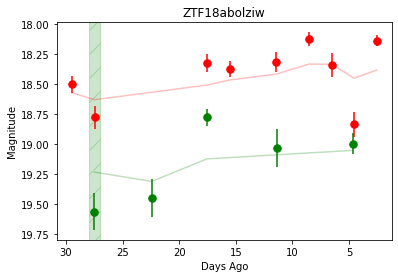

https://lasair.roe.ac.uk/object/ZTF18abolziw/


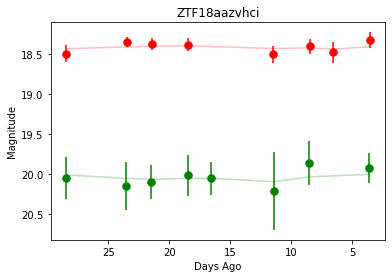

https://lasair.roe.ac.uk/object/ZTF18aazvhci/


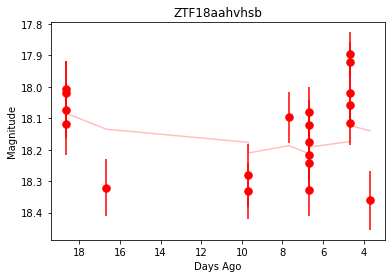

https://lasair.roe.ac.uk/object/ZTF18aahvhsb/


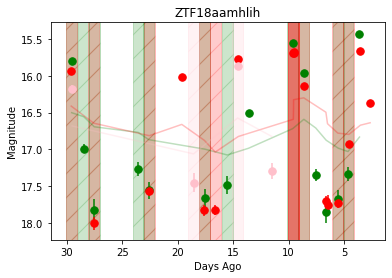

https://lasair.roe.ac.uk/object/ZTF18aamhlih/


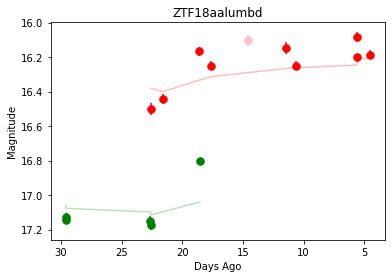

https://lasair.roe.ac.uk/object/ZTF18aalumbd/


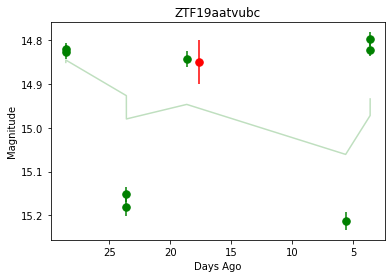

https://lasair.roe.ac.uk/object/ZTF19aatvubc/


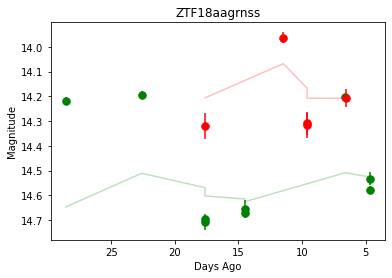

https://lasair.roe.ac.uk/object/ZTF18aagrnss/


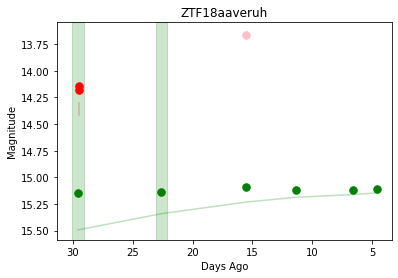

https://lasair.roe.ac.uk/object/ZTF18aaveruh/


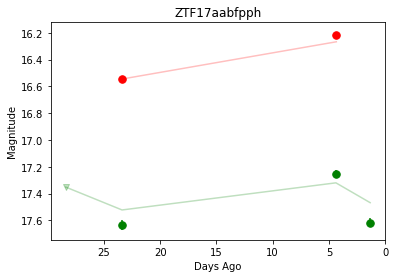

https://lasair.roe.ac.uk/object/ZTF17aabfpph/


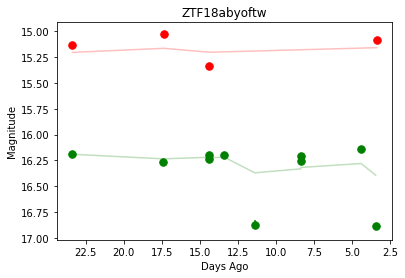

https://lasair.roe.ac.uk/object/ZTF18abyoftw/


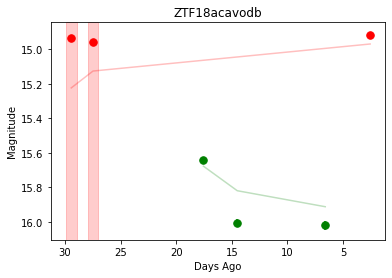

https://lasair.roe.ac.uk/object/ZTF18acavodb/


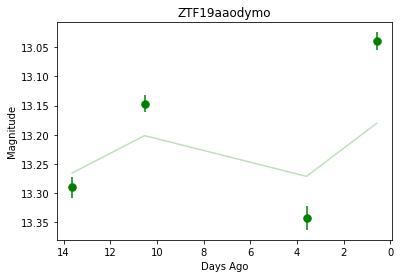

https://lasair.roe.ac.uk/object/ZTF19aaodymo/


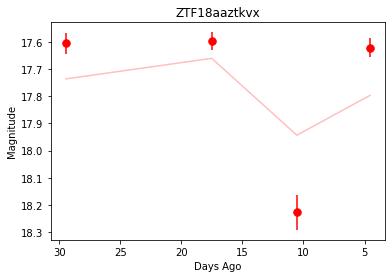

https://lasair.roe.ac.uk/object/ZTF18aaztkvx/


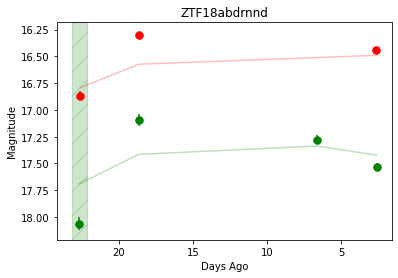

https://lasair.roe.ac.uk/object/ZTF18abdrnnd/


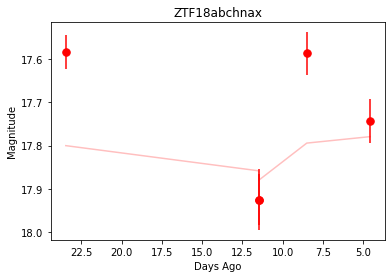

https://lasair.roe.ac.uk/object/ZTF18abchnax/


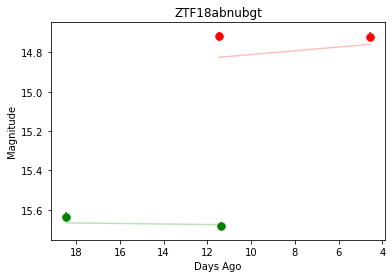

https://lasair.roe.ac.uk/object/ZTF18abnubgt/


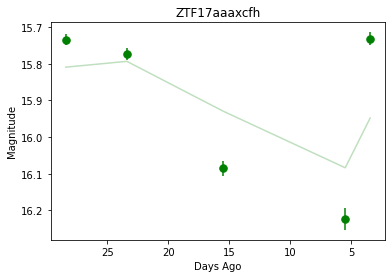

https://lasair.roe.ac.uk/object/ZTF17aaaxcfh/


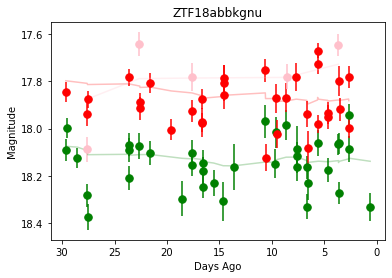

https://lasair.roe.ac.uk/object/ZTF18abbkgnu/


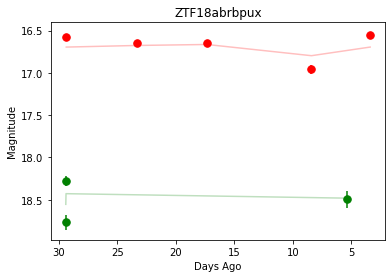

https://lasair.roe.ac.uk/object/ZTF18abrbpux/


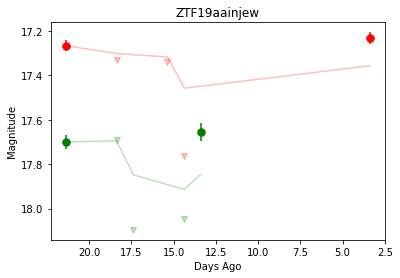

https://lasair.roe.ac.uk/object/ZTF19aainjew/


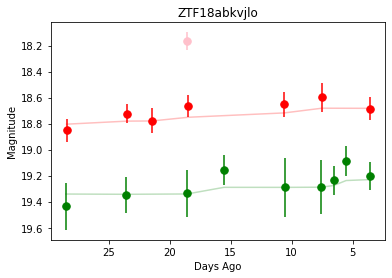

https://lasair.roe.ac.uk/object/ZTF18abkvjlo/


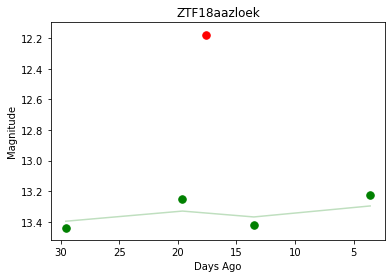

https://lasair.roe.ac.uk/object/ZTF18aazloek/


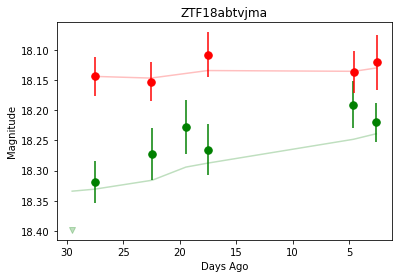

https://lasair.roe.ac.uk/object/ZTF18abtvjma/


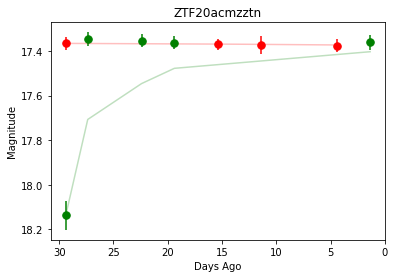

https://lasair.roe.ac.uk/object/ZTF20acmzztn/


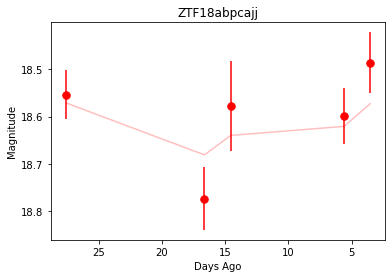

https://lasair.roe.ac.uk/object/ZTF18abpcajj/


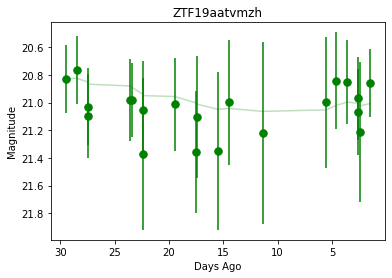

https://lasair.roe.ac.uk/object/ZTF19aatvmzh/


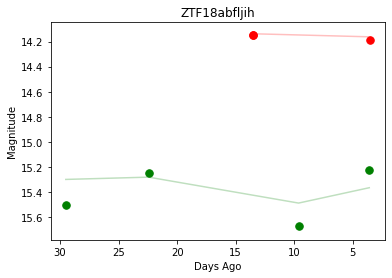

https://lasair.roe.ac.uk/object/ZTF18abfljih/


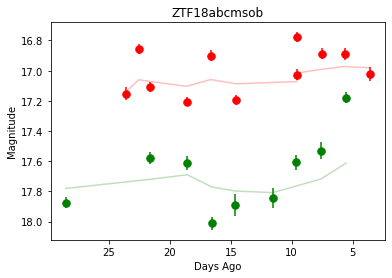

https://lasair.roe.ac.uk/object/ZTF18abcmsob/


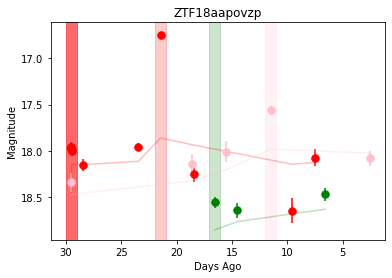

https://lasair.roe.ac.uk/object/ZTF18aapovzp/


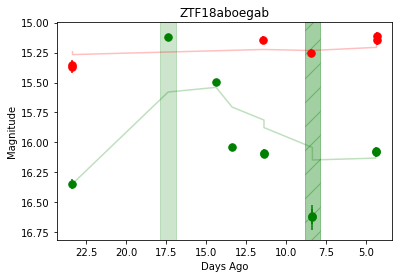

https://lasair.roe.ac.uk/object/ZTF18aboegab/


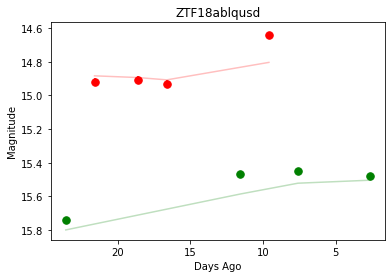

https://lasair.roe.ac.uk/object/ZTF18ablqusd/


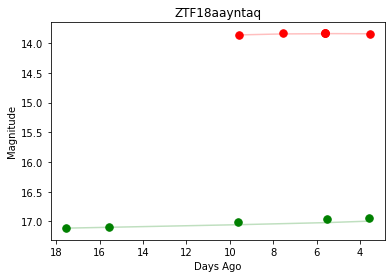

https://lasair.roe.ac.uk/object/ZTF18aayntaq/


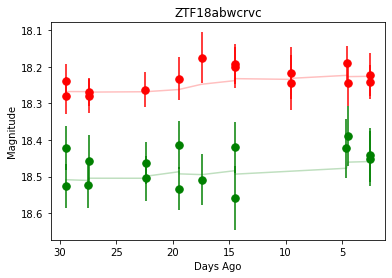

https://lasair.roe.ac.uk/object/ZTF18abwcrvc/


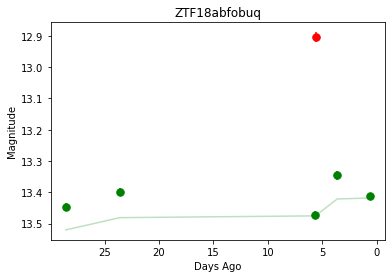

https://lasair.roe.ac.uk/object/ZTF18abfobuq/


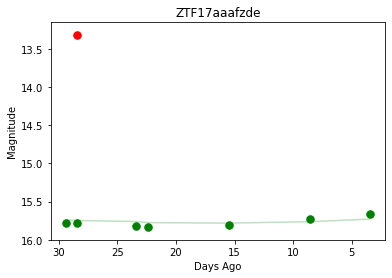

https://lasair.roe.ac.uk/object/ZTF17aaafzde/


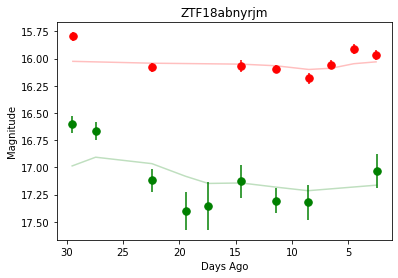

https://lasair.roe.ac.uk/object/ZTF18abnyrjm/


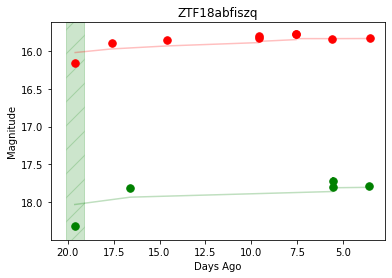

https://lasair.roe.ac.uk/object/ZTF18abfiszq/


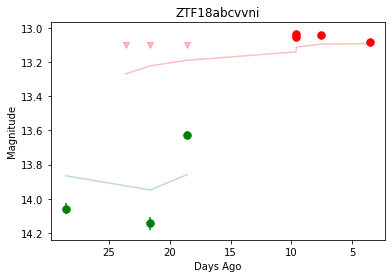

https://lasair.roe.ac.uk/object/ZTF18abcvvni/


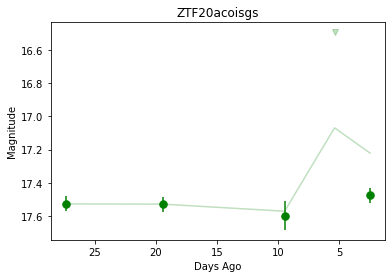

https://lasair.roe.ac.uk/object/ZTF20acoisgs/


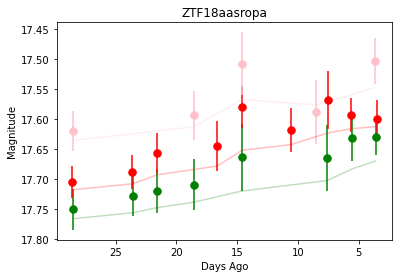

https://lasair.roe.ac.uk/object/ZTF18aasropa/


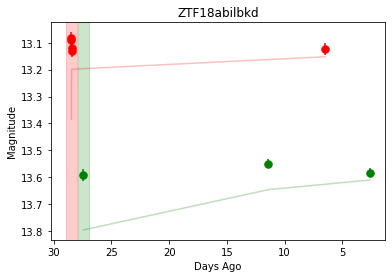

https://lasair.roe.ac.uk/object/ZTF18abilbkd/


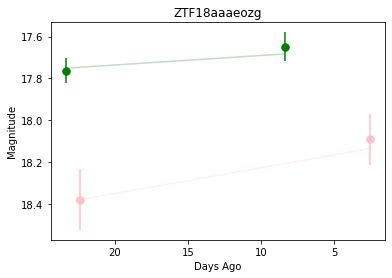

https://lasair.roe.ac.uk/object/ZTF18aaaeozg/


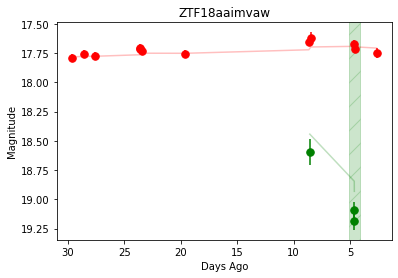

https://lasair.roe.ac.uk/object/ZTF18aaimvaw/


In [84]:
for x in combined_order_by_max[:200]:
    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag_ulim'])
    if len(sub) > 3:
        plot_dc_lightcurve_lim(sub.reset_index(), x, ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=offset)
        print(f'https://lasair.roe.ac.uk/object/{x}/')
    # mark_seen(conn, x)
    # show_stamps(x)
    


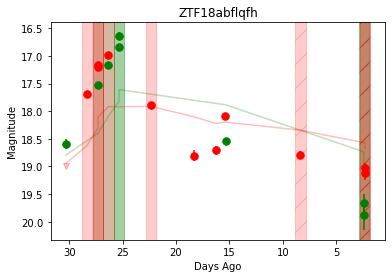

https://lasair.roe.ac.uk/object/ZTF18abflqfh/


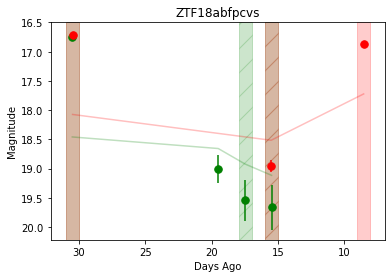

https://lasair.roe.ac.uk/object/ZTF18abfpcvs/


In [43]:
for x in ['ZTF18abflqfh', 'ZTF18abfpcvs']:
    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag_ulim'])
    if len(sub) > 3:
        plot_dc_lightcurve_lim(sub.reset_index(), x, ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=offset)
        print(f'https://lasair.roe.ac.uk/object/{x}/')
    # mark_seen(conn, x)
    # show_stamps(x)
    


In [ ]:
test_sub = dflc_interest_new.loc['ZTF17aabwtnr'].dropna(subset=['dc_mag'])

## Set up panels

In [ ]:
import panel as pn
pn.extension()

def create_alert_panel(conn, data, ztf_object_id, im_dir, plot_lc_kwargs):
    lc_plot = plot_dc_lightcurve(data, ztf_object_id, **plot_lc_kwargs)
    stamps = show_stamps(ztf_object_id, im_dir)
    
    mark_seen = pn.widgets.Toggle(name='Mark Seen', value=True)
    mark_interest = pn.widgets.Toggle(name='Mark Interest')
    
    notes = pn.widgets.TextInput(value='Notes', width=750)
    
    def b(event):
        if notes.value == 'Notes':
            notes = '""'
        else:
            notes = f'"{notes}"'
        data_to_update = {"seen_flag": mark_seen.value, "interest_flag": mark_interest.value,
                  "notes": notes}
        # update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')
        print(data_to_update)
        output.value = 'testing...'
    submit = pn.widgets.Button(name='Submit', color='danger')
    submit.on_click(b)
    
    output = pn.widgets.TextInput(value='Output')
    test_panel = pn.Column(pn.Row(f'#{ztf_object_id}', align='center'), 
                           pn.Row(lc_plot, align='center'),
                           pn.Row(mark_seen, mark_interest, align='center'),
                           pn.Row(stamps),
                           pn.Row(notes, align='center'),
                           pn.Row(submit, output, align='center'))
    return test_panel

In [ ]:
plot_lc_kwargs = {'ema': 'ema8', 'ema_diff': 'mag_ewm_diff8_rolling4', 'offset':offset, 'show':False}
ztf_object_id = 'ZTF17aabwtnr'
test = create_alert_panel(conn, dflc_interest_new.loc[ztf_object_id].dropna(subset=['dc_mag']).reset_index(), ztf_object_id, cutout_dir, plot_lc_kwargs)


In [ ]:
test

### check if updating worked 
not working yet

In [ ]:
conn = sqlite3.connect('../local/db/sqlite_pid2.db')
df = pd.read_sql_query("SELECT * FROM ZTF_objects", conn)
df.columns = ['ztf_object_id', 'SIMBAD_otype', 'ra', 'dec', 'ROSAT_IAU_NAME',
       'SIMBAD_include', 'last_obs', 'seen_flag', 'interest_flag', 'notes']
df.query('ztf_object_id == "ZTF18aabefzb"')
df.query('ztf_object_id == "ZTF17aaairkd"')

In [ ]:
# example updating
# data_to_update = {"seen_flag": 1, "interest_flag": 0,
#                   "notes": '"testing"'}
data_to_update = {"seen_flag": 0, "interest_flag": 1,
                  "notes": '""'}
update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')

## Explore panels

In [ ]:
import hvplot.pandas
from bokeh.sampledata.autompg import autompg

def autompg_plot(x='mpg', y='hp', color='#058805'):
    return autompg.hvplot.scatter(x, y, c=color, padding=0.1)

columns = list(autompg.columns[:-2])

In [ ]:
color = pn.widgets.ColorPicker(name='Color', value='#4f4fdf')
layout = pn.interact(autompg_plot, x=columns, y=columns, color=color)

pn.Row(pn.Column('## MPG Explorer', layout[0]), layout[1])

In [ ]:
columns

In [ ]:
x = pn.widgets.Select(value='mpg', options=columns, name='x')
y = pn.widgets.Select(value='hp', options=columns, name='y')
color = pn.widgets.ColorPicker(name='Color', value='#880588')

layout = pn.Row(
    pn.Column('## MPG Explorer', x, y, color),
    autompg_plot(x.value, y.value, color.value))

def update(event):
    layout[1].object = autompg_plot(x.value, y.value, color.value)

x.param.watch(update, 'value')
y.param.watch(update, 'value')
color.param.watch(update, 'value')

layout

In [1]:
autompg_plot(x.value, y.value, color.value)

NameError: name 'autompg_plot' is not defined

In [60]:
ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')


In [76]:
import param


In [91]:
class ZTF_panel(param.Parameterized):
    update = param.Action(lambda self: self._action_update())
    
    def __init__(self, **params):
        super(ZTF_panel, self).__init__(**params)
        self.ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')
        self.fig = plot_dc_lightcurve(dflc_interest_new.loc[self.ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), self.ztf_object_id.value, **plot_lc_kwargs)
        self.mpl = pn.pane.Matplotlib(self.fig)
        
    @param.depends('update', watch=True)    
    def _action_update(self):
        
        self.fig = plot_dc_lightcurve(dflc_interest_new.loc[self.ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), self.ztf_object_id.value, **plot_lc_kwargs)
        self.mpl.param.trigger('object')
    
    def panel(self):
        return pn.Column(pn.Row(f'#{self.ztf_object_id.value}', align='center'), 
                   pn.Row(self.ztf_object_id),
                       pn.Row(self.mpl, align='center'))

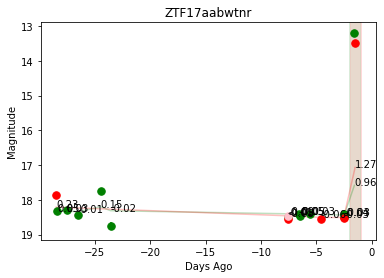

In [92]:
test = ZTF_panel()

In [83]:
print(test.panel())

Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row
        [0] Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF18aauqlbf')
    [2] Row(align='center')
        [0] Matplotlib(Figure)


Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row
        [0] Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF17aabwtnr')
    [2] Row(align='center')
        [0] Matplotlib(Figure)
    [3] Row(align='center')
        [0] Toggle(name='Mark Seen', value=True)
        [1] Toggle(name='Mark Interest')
    [4] Row(align='center')
        [0] TextInput(value='Notes', width=750)
    [5] Row(align='center')
        [0] Button(name='Submit')
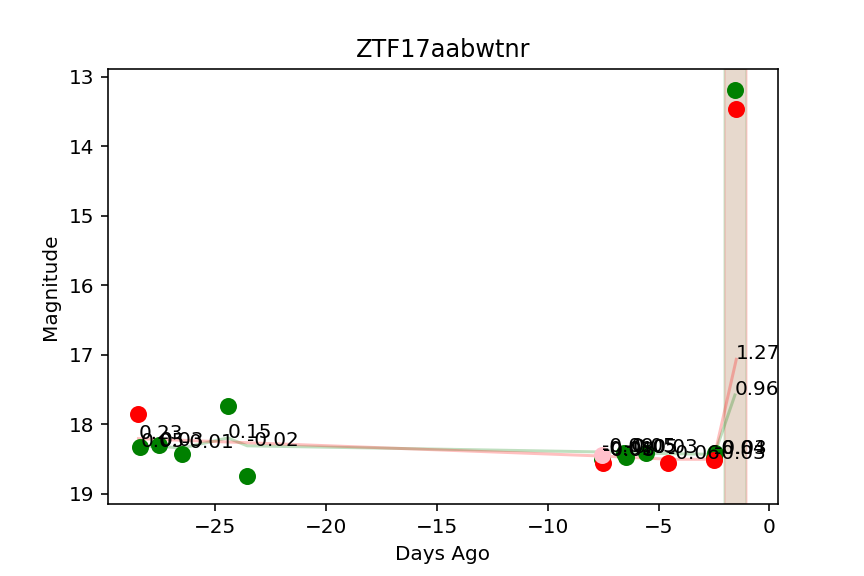

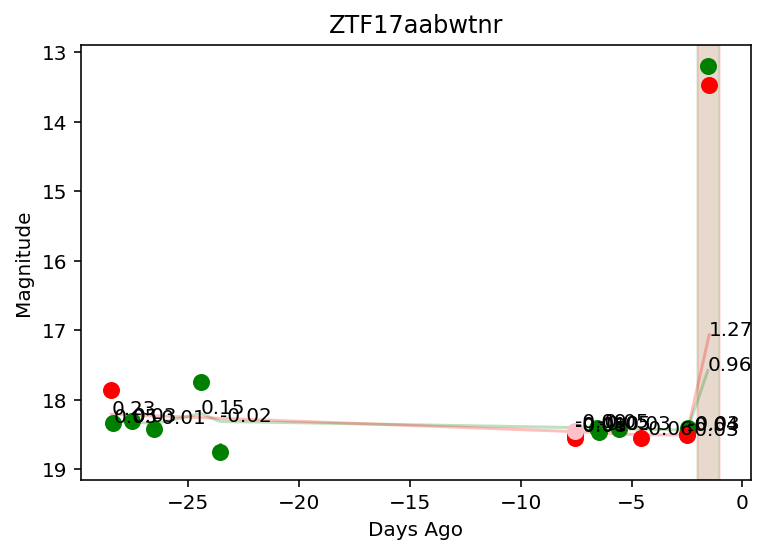

In [72]:
ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')

# stamps = show_stamps(ztf_object_id.value, im_dir)
mpl_pane = pn.pane.Matplotlib(plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), ztf_object_id.value, **plot_lc_kwargs), dpi=144)

mark_seen = pn.widgets.Toggle(name='Mark Seen', value=True)
mark_interest = pn.widgets.Toggle(name='Mark Interest')

notes = pn.widgets.TextInput(value='Notes', width=750)

def b(event):
    if notes.value == 'Notes':
        notes = '""'
    else:
        notes = f'"{notes}"'
    data_to_update = {"seen_flag": mark_seen.value, "interest_flag": mark_interest.value,
              "notes": notes}
    # update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')
    print(data_to_update)
    output.value = 'testing...'
    
def update(event):
    mpl_pane = pn.pane.Matplotlib(plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), ztf_object_id.value, **plot_lc_kwargs), dpi=144)
    layout[2].object = mpl_pane
    
submit = pn.widgets.Button(name='Submit')
# submit.on_click(b)

layout = pn.Column(pn.Row(f'#{ztf_object_id.value}', align='center'), 
                   pn.Row(ztf_object_id),
                       pn.Row(mpl_pane, align='center'),
                       pn.Row(mark_seen, mark_interest, align='center'),
                       # pn.Row(stamps),
                       pn.Row(notes, align='center'),
                       pn.Row(submit, align='center'))

ztf_object_id.param.watch(update, 'value')

layout

Matplotlib(Figure)
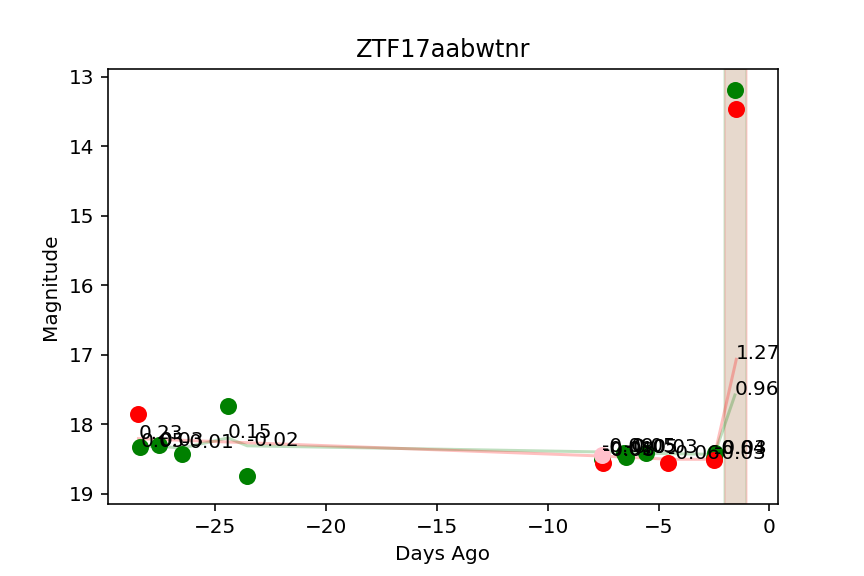

In [73]:
mpl_pane

In [96]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

import matplotlib.pyplot as plt

breast_cancer = load_breast_cancer()

print("Feature Names", breast_cancer.feature_names)
print("Target : ", breast_cancer.target_names)
print("Dataset Size : ", breast_cancer.data.shape)

breast_cancer_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df["Target"] = breast_cancer.target
breast_cancer_df["Target"] = ['Malignant' if typ==0 else 'Benign' for typ in breast_cancer_df["Target"]]
breast_cancer_df.head()

Feature Names ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target :  ['malignant' 'benign']
Dataset Size :  (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,Malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,Malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,Malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,Malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,Malignant


In [97]:
import matplotlib.gridspec as gridspec

def create_figure(plot1_f1,plot1_f2, plot2_f,plot3_f):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) ## Declaring 2x2 figure.

        ax1 = fig.add_subplot(specs[0, :]) ## First Row
        ax2 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
        ax3 = fig.add_subplot(specs[1, 1]) ## Second Row Second Colums

        ## First Graph -  Scatter Plot
        color = {"Malignant" : "tab:red", "Benign":"tab:green"}
        for tumor_typ in breast_cancer_df["Target"].unique():
            ax1.scatter(breast_cancer_df[breast_cancer_df["Target"]==tumor_typ][plot1_f1],
                        breast_cancer_df[breast_cancer_df["Target"]==tumor_typ][plot1_f2],
                        c=color[tumor_typ],
                        s=200,
                        alpha=0.6,
                        label=tumor_typ)
        ax1.set_xlabel(plot1_f1)
        ax1.set_ylabel(plot1_f2)
        ax1.set_title("%s vs %s Scatter Plot"%(plot1_f1, plot1_f2))
        ax1.legend(title="Tumor Type",loc="best")

        ## Second Graph - Bar Chart
        avg_radius_per_tumor_typ = breast_cancer_df.groupby(by="Target").mean()[[plot2_f]]
        ax2.bar(avg_radius_per_tumor_typ.index,
                avg_radius_per_tumor_typ[plot2_f],
                color="tab:blue",
                width=0.6)
        ax2.set_ylabel(plot2_f)
        ax2.set_title("Average %s per tumor type"%(plot2_f))

        ## Third Graph - Histogram
        ax3.hist(breast_cancer_df[plot3_f], color="tab:orange", )
        ax3.set_ylabel(plot3_f)
        ax3.set_title("%s distribution"%(plot3_f))

        plt.close(fig)
        return fig

In [101]:
f1 = pn.widgets.Select(options=list(breast_cancer.feature_names), name="Scatter Plot Feature 1")
f2 = pn.widgets.Select(options=list(breast_cancer.feature_names), name="Scatter Plot Feature 2")
f3 = pn.widgets.Select(options=list(breast_cancer.feature_names), name="Bar Chart Feature")
f4 = pn.widgets.Select(options=list(breast_cancer.feature_names), name="Histogram Feature")

In [105]:
f1

Select(name='Scatter Plot Feature 1', options=['mean radius', ...], value='mean smoothness')

In [108]:
@pn.depends(f1.param.value,f2.param.value,f3.param.value,f4.param.value)
def create_dash(f1,f2,f3,f4):
    return create_figure(f1,f2,f3,f4)

Column
    [0] StaticText(align='center', value='<h3>Breast Cancer D...)
    [1] Row(align='center')
        [0] Select(name='Scatter Plot Feature 1', options=['mean radius', ...], value='mean smoothness')
        [1] Select(name='Scatter Plot Feature 2', options=['mean radius', ...], value='mean radius')
    [2] Row(align='center')
        [0] Select(name='Bar Chart Feature', options=['mean radius', ...], value='mean radius')
        [1] Select(name='Histogram Feature', options=['mean radius', ...], value='mean radius')
    [3] Row
        [0] ParamFunction(function)
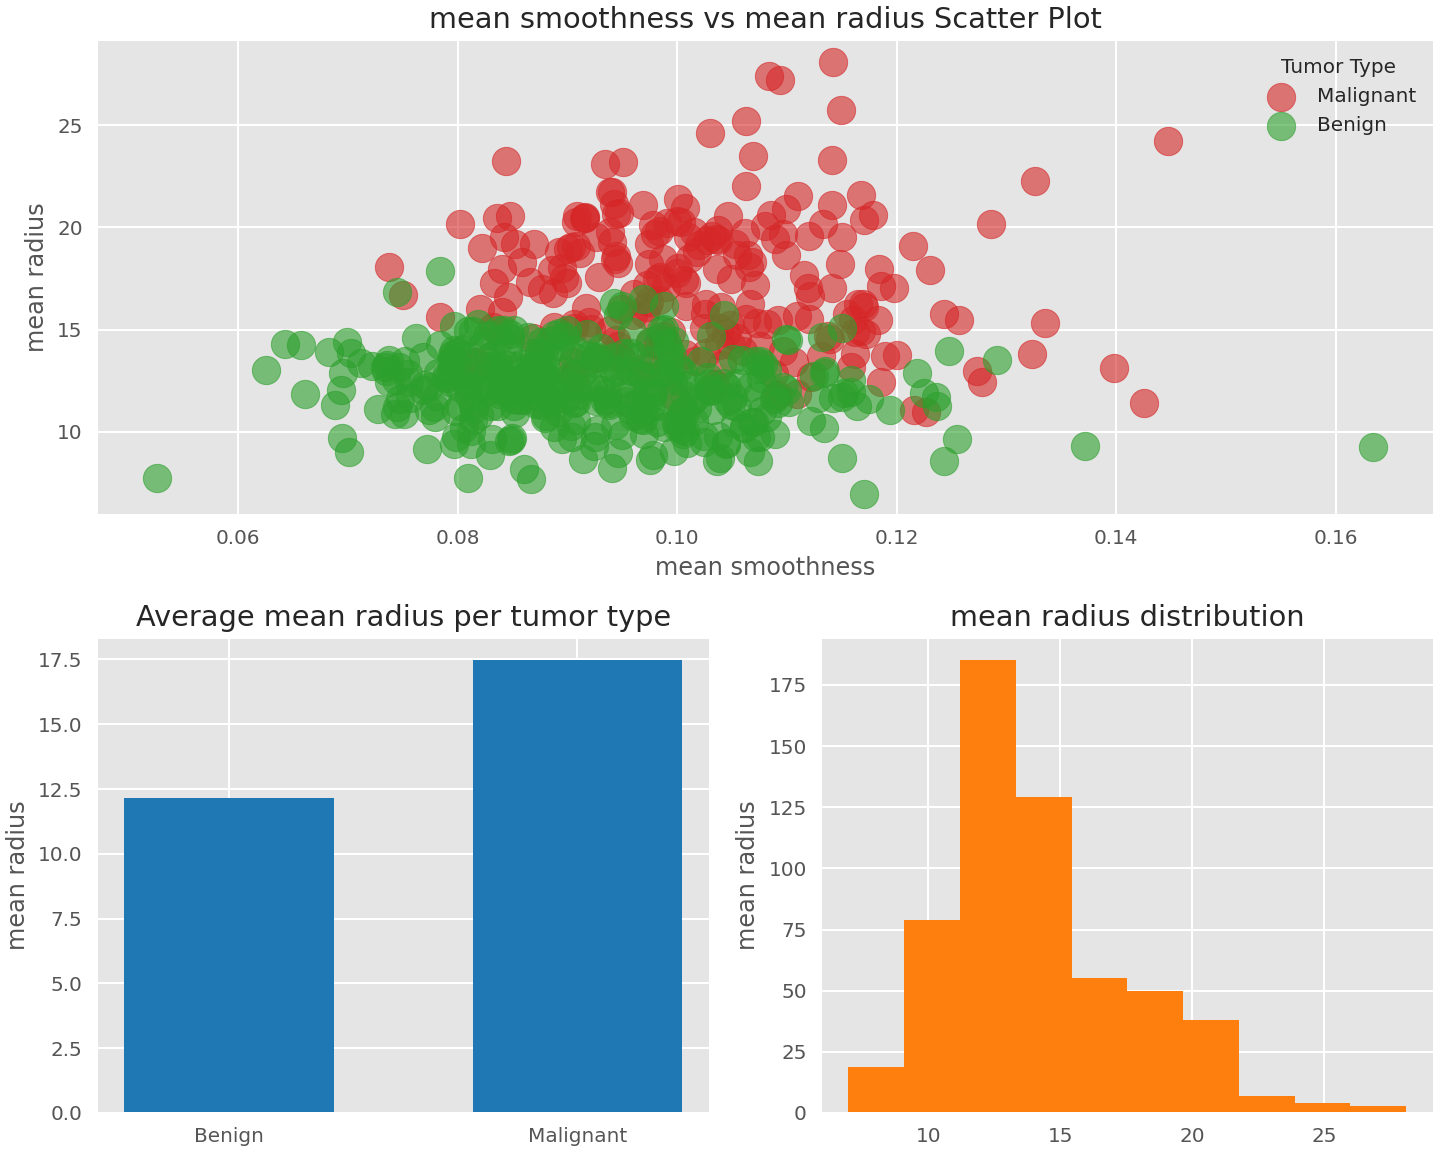

In [109]:
heading = "<h3>Breast Cancer Data Analysis Dashboard</h3>\nPlease feel free to try various combinations of parameters to analyze results from different angles"
text = pn.widgets.StaticText(value=heading, align="center")

dash3 = pn.Column(
                    text,
                    pn.Row(f1,f2, align="center"),
                    pn.Row(f3,f4, align="center"),
                    pn.Row(create_dash)
                )
dash3

test


test

Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row
        [0] Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF17aabwtnr')
    [2] Row
        [0] Button(name='Next')
    [3] Row(align='center')
        [0] ParamFunction(function)
    [4] Row(align='center')
        [0] ParamFunction(function)
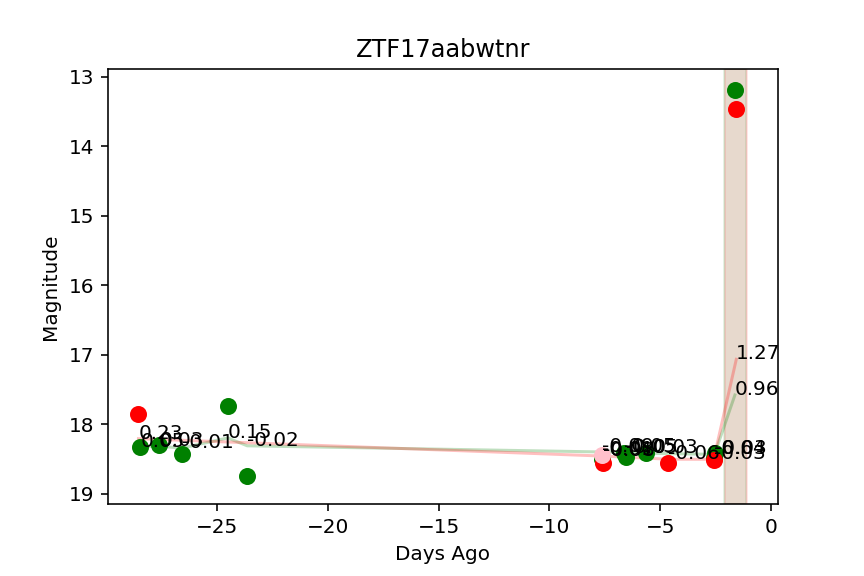
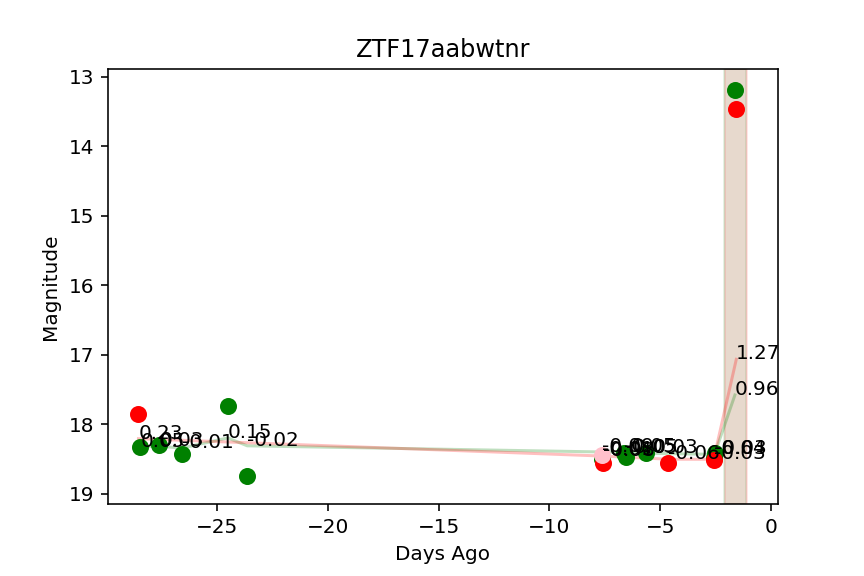

In [136]:
ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')

# stamps = show_stamps(ztf_object_id.value, im_dir)
mpl_pane = pn.pane.Matplotlib(plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), ztf_object_id.value, **plot_lc_kwargs), dpi=144)

ii=0
@pn.depends(ztf_object_id.param.value)
def create_dash(ztf_object_id):
    print('test')
    return plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id].dropna(subset=['dc_mag']).reset_index(), ztf_object_id, **plot_lc_kwargs)

submit = pn.widgets.Button(name='Next')

@pn.depends(submit.param.value)
def create_dash2(mpl_pane):
    # print('test')
    return plot_dc_lightcurve(dflc_interest_new.loc[order_by_max[submit.clicks]].dropna(subset=['dc_mag']).reset_index(), order_by_max[submit.clicks], **plot_lc_kwargs)


layout = pn.Column(pn.Row(f'#{ztf_object_id.value}', align='center'), 
                   pn.Row(ztf_object_id),
                   pn.Row(submit),
                   pn.Row(create_dash, align='center'),
                   pn.Row(create_dash2, align='center'))


# ztf_object_id.param.watch(update, 'value')
layout

In [133]:
ztf_object_id

Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF18abbuvrd')

In [135]:
ztf_object_id.value = 'ZTF18abbuvrd'

Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row
        [0] Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF17aabwtnr')
    [2] Row
        [0] Button(name='Previous')
        [1] Button(name='Next')
    [3] Row(align='center')
        [0] ParamFunction(function)
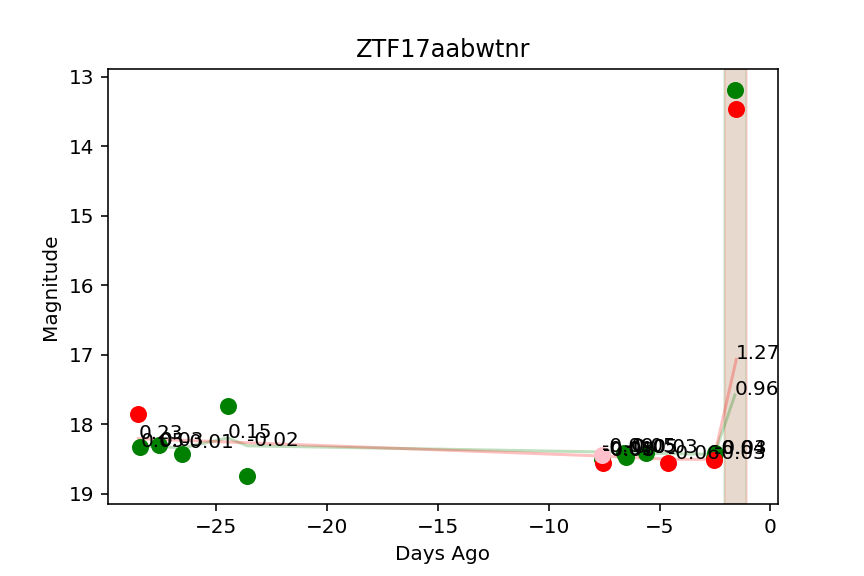

In [130]:
ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')

# stamps = show_stamps(ztf_object_id.value, im_dir)
mpl_pane = pn.pane.Matplotlib(plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), ztf_object_id.value, **plot_lc_kwargs), dpi=144)

ii=0
@pn.depends(ztf_object_id.param.value, submit.param.value)
def create_dash(obj_id, goto_next, goto_prev):
    return plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id].dropna(subset=['dc_mag']).reset_index(), ztf_object_id, **plot_lc_kwargs)

submit = pn.widgets.Button(name='Next')
prev = pn.widgets.Button(name='Previous')

layout = pn.Column(pn.Row(f'#{ztf_object_id.value}', align='center'), 
                   pn.Row(ztf_object_id),
                   pn.Row(prev, submit),
                   pn.Row(create_dash, align='center'))


# ztf_object_id.param.watch(update, 'value')
layout

### Add columns to existing dbs

In [81]:
def add_column(conn, table, col_name, col_type):
    cur = conn.cursor()
    cur.execute(f"ALTER TABLE {table} ADD COLUMN {col_name} {col_type};")
    return pd.read_sql_query(f"SELECT * FROM {table}", conn).dtypes


In [133]:
conn_debug = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')


In [134]:
add_column(conn_debug, 'ZTF_objects', 'last_obs', 'float')
add_column(conn_debug, 'ZTF_objects', 'seen_flag', 'int')
add_column(conn_debug, 'ZTF_objects', 'interest_flag', 'int')
add_column(conn_debug, 'ZTF_objects', 'notes', 'text')

ZTF_object_id      object
SIMBAD_otype       object
ra                float64
dec               float64
ROSAT_IAU_NAME     object
SIMBAD_include    float64
last_obs           object
seen_flag          object
interest_flag      object
notes              object
dtype: object

In [90]:
pd.read_sql_query("SELECT * FROM lightcurves", conn).dtypes

ZTF_object_id     object
jd                object
fid               object
magpsf           float64
sigmapsf         float64
diffmaglim       float64
isdiffpos         object
magnr            float64
sigmagnr         float64
dtype: object

In [182]:
conn_debug = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')

pd.read_sql_query("SELECT * FROM ZTF_objects", conn_debug).dropna(subset=['ra'])

,ZTF_object_id,SIMBAD_otype,ra,dec,ROSAT_IAU_NAME,SIMBAD_include,last_obs,seen_flag,interest_flag,notes
30,ZTF18aabezub,None,40.207699,49.865258,2RXS J024048.8+495203,0.0,2.459270e+06,0.0,0.0,None
31,ZTF18acmysaq,BLL,53.486514,65.615648,2RXS J033357.0+653705,0.0,2.459270e+06,0.0,0.0,None
32,ZTF20aaffcza,None,57.535898,76.662918,2RXS J035011.9+764002,0.0,2.459270e+06,0.0,0.0,None
33,ZTF18absqkfg,G,43.684938,47.442902,2RXS J025444.0+472639,0.0,2.459270e+06,0.0,0.0,None
34,ZTF19abjolmq,None,64.610641,73.275639,2RXS J041824.0+731635,0.0,2.459270e+06,0.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...
336,ZTF18acbzkta,None,63.756536,32.335179,2RXS J041501.6+322002,0.0,2.459270e+06,0.0,0.0,None
337,ZTF18abydmyu,DN*,86.951510,28.586512,2RXS J054748.5+283511,1.0,2.459270e+06,0.0,1.0,None
338,ZTF18achucnm,None,63.549904,36.601002,2RXS J041413.5+363554,0.0,2.459270e+06,0.0,0.0,None
339,ZTF18acdyfgs,QSO,38.043686,32.663463,2RXS J023209.8+323932,0.0,2.459270e+06,0.0,0.0,None


In [84]:
cnx = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitesimple.db')
add_column(cnx, 'lightcurves', 'field', 'int')
add_column(cnx, 'lightcurves', 'rcid', 'int')
pd.read_sql_query("SELECT * FROM lightcurves", cnx)

,ZTF_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid
0,ZTF19abceihx,2459218.6020023,1,19.221775,0.175954,19.369980,f,17.524000,0.014,None,None
1,ZTF19abceihx,2459189.6685648,2,19.011000,0.137446,19.469000,f,17.299000,0.018,None,None
2,ZTF19abceihx,2459189.6930556,2,18.864500,0.107180,19.620899,f,17.243000,0.020,None,None
3,ZTF19abceihx,2459192.6256366,2,18.951799,0.252563,18.841499,f,17.299000,0.018,None,None
4,ZTF19abceihx,2459192.627037,2,18.754900,0.192248,18.947001,f,17.243000,0.020,None,None
...,...,...,...,...,...,...,...,...,...,...,...
374540,ZTF18abtoupn,2459274.0565162,2,15.225590,0.020630,18.288145,f,14.506000,0.020,None,None
374541,ZTF18aborthl,2459274.0565162,2,17.907963,0.153364,18.162607,f,16.231001,0.026,None,None
374542,ZTF18abtovjo,2459274.0545486,2,17.512791,0.111764,18.462793,t,16.457001,0.015,None,None
374543,ZTF18absuniq,2459274.0574537,2,17.610895,0.168301,18.063719,t,15.917999,0.016,None,None


In [89]:
cnx = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')
pd.read_sql_query("SELECT * FROM lightcurves", cnx)

,ZTF_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid
0,ZTF18aabezub,2459269.6372801,2,18.705532,0.082297,20.220669,f,18.289000,0.020,NaN,NaN
1,ZTF18aabezub,2459248.6617593,2,18.890499,0.094581,20.413300,f,18.289000,0.020,NaN,NaN
2,ZTF18aabezub,2459248.7015972,1,18.811001,0.095207,20.477900,f,18.368999,0.034,NaN,NaN
3,ZTF18aabezub,2459250.6761574,2,18.921400,0.107312,19.907301,f,18.289000,0.020,NaN,NaN
4,ZTF18aabezub,2459250.7026157,1,18.815800,0.110672,20.051100,f,18.368999,0.034,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
40024,ZTF21aanswqf,2459274.0574537,2,NaN,NaN,17.979700,None,NaN,NaN,542.0,20.0
40025,ZTF21aanswqf,2459275.0508449,2,NaN,NaN,18.607500,None,NaN,NaN,542.0,20.0
40026,ZTF21aanswqf,2459275.0532755,2,NaN,NaN,18.440001,None,NaN,NaN,542.0,20.0
40027,ZTF18abtovjo,2459275.0552431,2,17.455315,0.076400,18.567413,t,16.457001,0.015,593.0,31.0


### Investigate distribution of metric

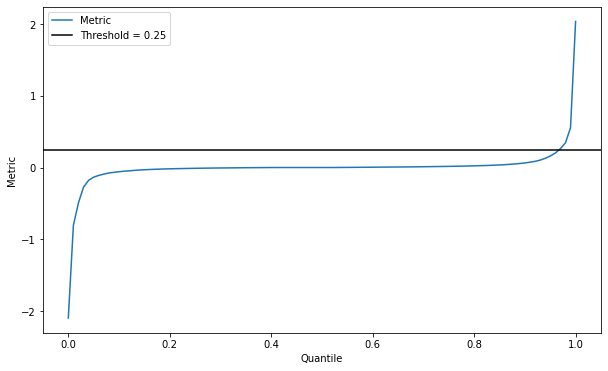

In [94]:
plt.figure(figsize=(10,6))
dflc_interest['mag_ewm_diff8_rolling4'].quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Metric')
plt.axhline(0.25, color='k', label='Threshold = 0.25')
plt.legend()
plt.show()

In [179]:
cand=pd.read_csv('ZTF19aanxwrq.csv')

In [180]:
cand['dc_mag_ulim'] = cand['diffmaglim'] #-2.5 * np.log10(10**(-0.4*cand['magnr']) + 10**(-0.4*cand['diffmaglim']))
# cand['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*cand['magnr']) - 10**(-0.4*cand['diffmaglim']))
cand['combined_mag_ulim'] = [cand.loc[ii, 'dc_mag_ulim'] if pd.isna(cand.loc[ii, 'dc_mag']) else cand.loc[ii, 'dc_mag'] for ii in cand.index]

In [189]:
cand['utc'] = pd.to_datetime(cand['utc'])

cand['ztf_object_id'] = 'ZTF19aanxwrq'

cand['jd'] = cand['mjd'] + 2400000

cand.set_index(['ztf_object_id', 'fid'], inplace=True)
cand = cand.sort_values('utc').sort_index()

In [190]:
cand['combined_ema8'] = cand.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='8 days', times=x['utc']).mean()).values
cand['combined_mag_ewm_diff8'] = cand['combined_mag_ulim'] - cand['combined_ema8']
cand['combined_mag_ewm_diff8_rolling4'] = cand.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

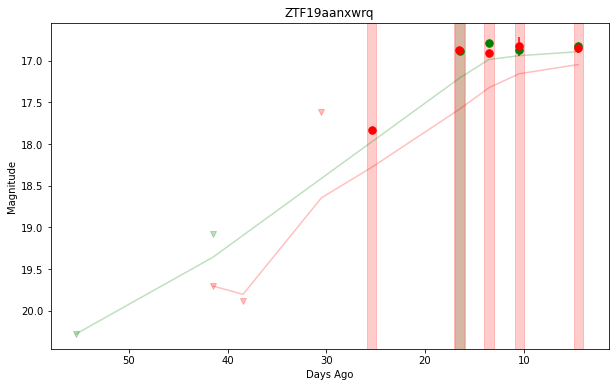

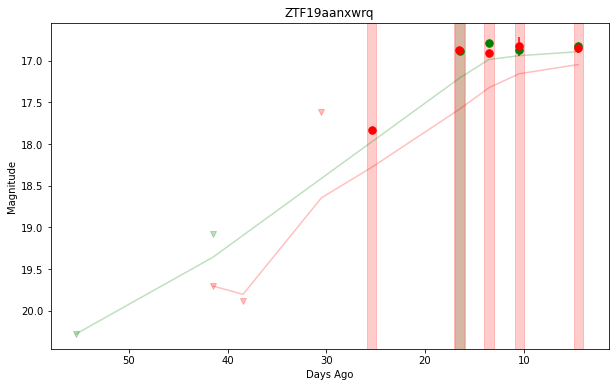

In [211]:

plot_dc_lightcurve_lim(cand2.reset_index(),'ZTF19aanxwrq', ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=770)

In [258]:
cand2 = cand.reset_index().sort_values('utc').iloc[:14]

In [259]:
cand3 = cand.reset_index().sort_values('utc').iloc[50:70]

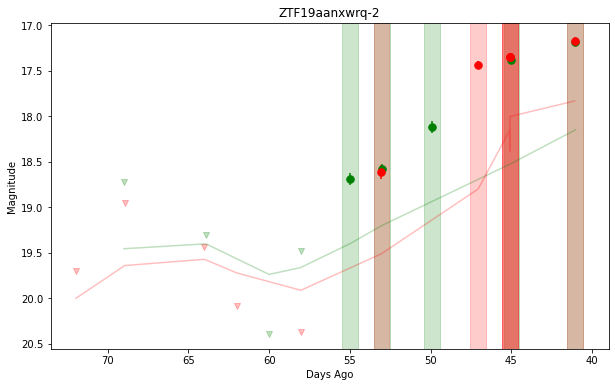

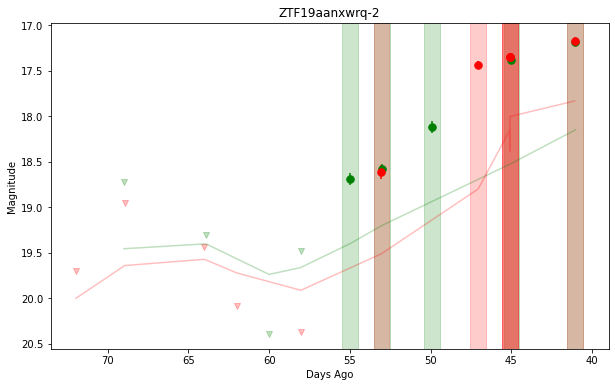

In [267]:
plot_dc_lightcurve_lim(cand3.reset_index(),'ZTF19aanxwrq-2', ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=0)

(58500.0, 58700.0)

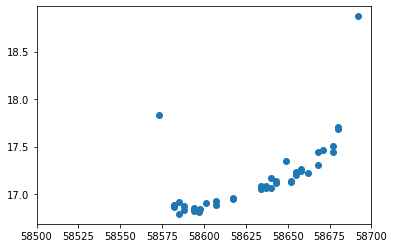

In [115]:
plt.scatter(cand['mjd'], cand['dc_mag'])
plt.xlim([58500, 58700])

In [156]:
cand.to_csv('ZTF19aanxwrq.csv', index=False)

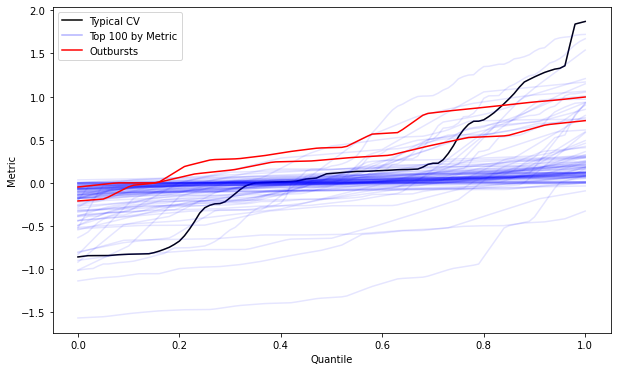

In [233]:
plt.figure(figsize=(10,6))

for i,x in enumerate(order_by_max[:100]):
    if i == 0:
        sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
        (-sub['mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', color='k', label='Typical CV')

    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
    (-sub['mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', color='b', alpha=.1, label='')

sub['mag_ewm_diff8_rolling4'].quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Top 100 by Metric', color='b', alpha=.3)
(-cand2['combined_mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Outbursts', color='red')
(-cand3['combined_mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='', color='red')
plt.legend()
plt.show()

In [ ]:
### Investigate distribution of metric

plt.figure(figsize=(10,6))
dflc_interest['mag_ewm_diff8_rolling4'].quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Metric')
plt.axhline(0.25, color='k', label='Threshold = 0.25')
plt.legend()
plt.show()

cand=pd.read_csv('ZTF19aanxwrq.csv')

cand['dc_mag_ulim'] = cand['diffmaglim'] #-2.5 * np.log10(10**(-0.4*cand['magnr']) + 10**(-0.4*cand['diffmaglim']))
# cand['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*cand['magnr']) - 10**(-0.4*cand['diffmaglim']))
cand['combined_mag_ulim'] = [cand.loc[ii, 'dc_mag_ulim'] if pd.isna(cand.loc[ii, 'dc_mag']) else cand.loc[ii, 'dc_mag'] for ii in cand.index]

cand['utc'] = pd.to_datetime(cand['utc'])

cand['ztf_object_id'] = 'ZTF19aanxwrq'

cand['jd'] = cand['mjd'] + 2400000

cand.set_index(['ztf_object_id', 'fid'], inplace=True)
cand = cand.sort_values('utc').sort_index()

cand['combined_ema8'] = cand.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='8 days', times=x['utc']).mean()).values
cand['combined_mag_ewm_diff8'] = cand['combined_mag_ulim'] - cand['combined_ema8']
cand['combined_mag_ewm_diff8_rolling4'] = cand.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values




plot_dc_lightcurve_lim(cand2.reset_index(),'ZTF19aanxwrq', ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=770)

cand2 = cand.reset_index().sort_values('utc').iloc[:14]

cand3 = cand.reset_index().sort_values('utc').iloc[50:70]

plot_dc_lightcurve_lim(cand3.reset_index(),'ZTF19aanxwrq-2', ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=0)

plt.scatter(cand['mjd'], cand['dc_mag'])
plt.xlim([58500, 58700])

cand.to_csv('ZTF19aanxwrq.csv', index=False)

plt.figure(figsize=(10,6))

for i,x in enumerate(order_by_max[:100]):
    if i == 0:
        sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
        (-sub['mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', color='k', label='Typical CV')

    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
    (-sub['mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', color='b', alpha=.1, label='')

sub['mag_ewm_diff8_rolling4'].quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Top 100 by Metric', color='b', alpha=.3)
(-cand2['combined_mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Outbursts', color='red')
(-cand3['combined_mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='', color='red')
plt.legend()
plt.show()

In [260]:
cand2['ztf_object_id'] = 'ZTF19aanxwrq-1'
cand3['ztf_object_id'] = 'ZTF19aanxwrq-2'

In [261]:
cand2.set_index(['ztf_object_id', 'fid'], inplace=True)
cand3.set_index(['ztf_object_id', 'fid'], inplace=True)

In [270]:
injection_recent = pd.concat([recent, cand2, cand3])

In [317]:
combined_order_by_max = injection_recent.groupby("ztf_object_id")['combined_mag_ewm_diff8_rolling4'].apply(lambda x: x.abs().max()).sort_values(ascending=False).index

In [264]:
injection_dflc_interest_new = pd.concat([dflc_interest_new, cand2, cand3])

In [274]:
len(combined_order_by_max)

369